In [138]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.date, event_log.actor_id,
        user.username, event_log.event_id, event.name
        from event_log
        join event on event.id = event_log.event_id
        join user on user.id = event_log.actor_id
        order by event_log.id
    """, db)
    df.set_index("id", inplace=True)
    return df

event_log = read_event_log()

In [6]:
df = event_log[(event_log["event_id"] == 5) & (event_log["username"] != "Legacy")].copy()
df = df.groupby("actor_id").aggregate({
    "date": "count",
    "username": "first",
    "actor_id": "first"
})
df.rename(columns={"date": "edits"}, inplace=True)
df["edits"].describe()

count     758.000000
mean      136.224274
std       388.561684
min         1.000000
25%         2.000000
50%        10.000000
75%        87.500000
max      5207.000000
Name: edits, dtype: float64

<AxesSubplot:ylabel='Frequency'>

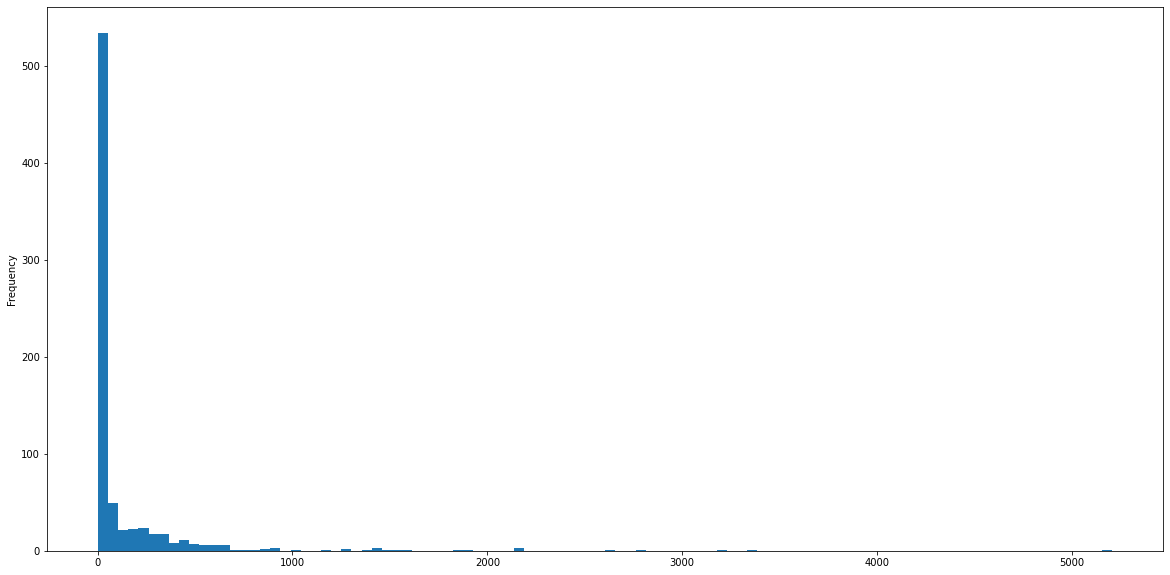

In [7]:
df["edits"].plot.hist(bins=100, figsize=(20,10))

<AxesSubplot:ylabel='Frequency'>

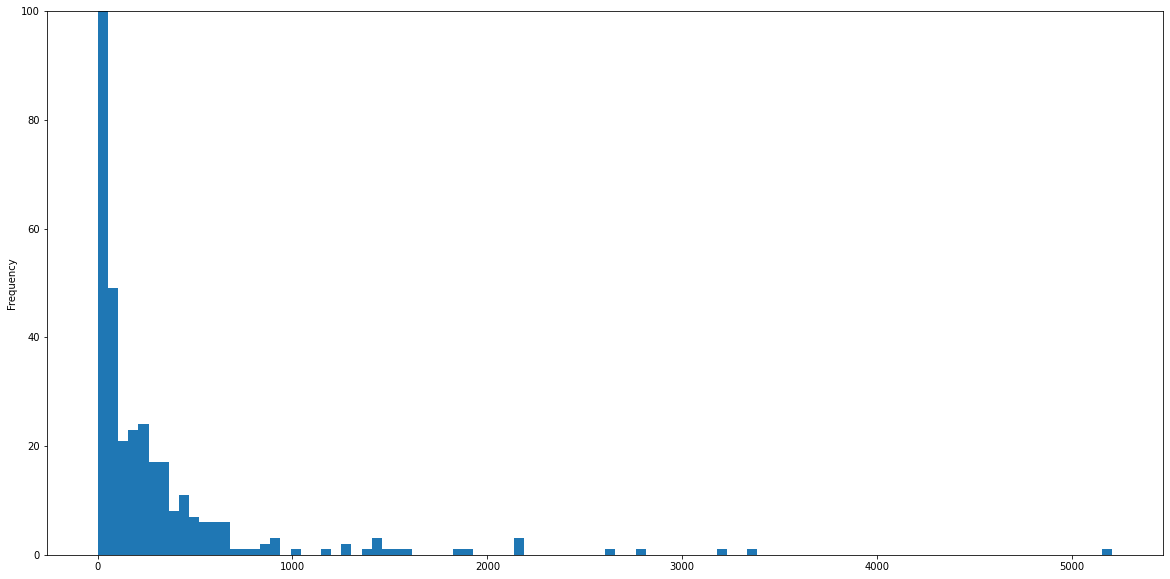

In [8]:
df["edits"].plot.hist(bins=100, figsize=(20,10), ylim=(0,100))

<AxesSubplot:ylabel='Frequency'>

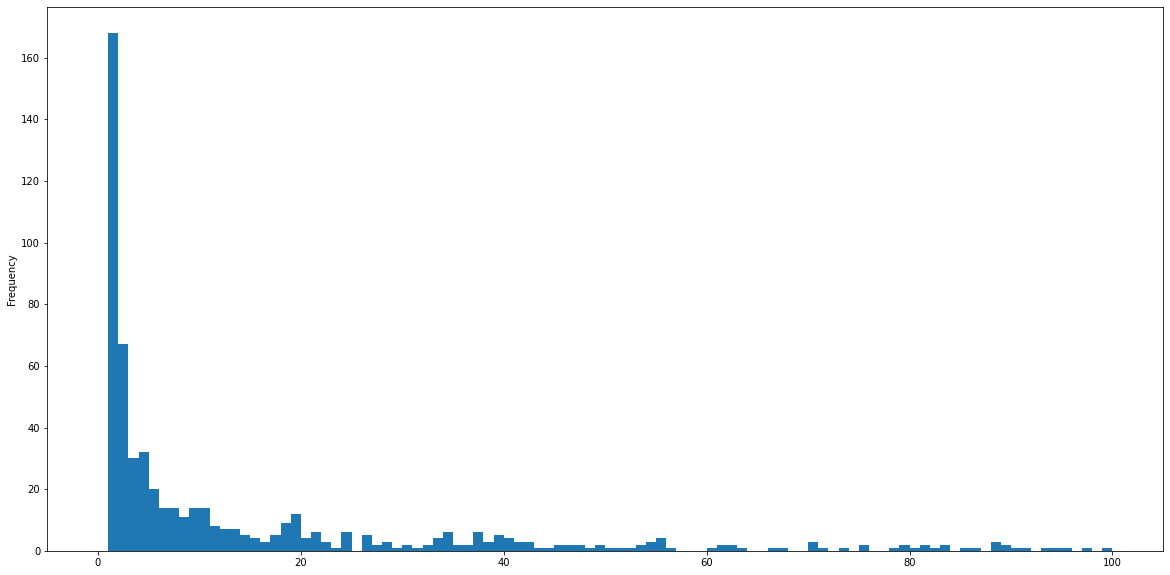

In [18]:
import numpy as np

m = 100
e = df["edits"]

e[e < m].plot.hist(bins=np.linspace(0,m,m+1), figsize=(20,10))

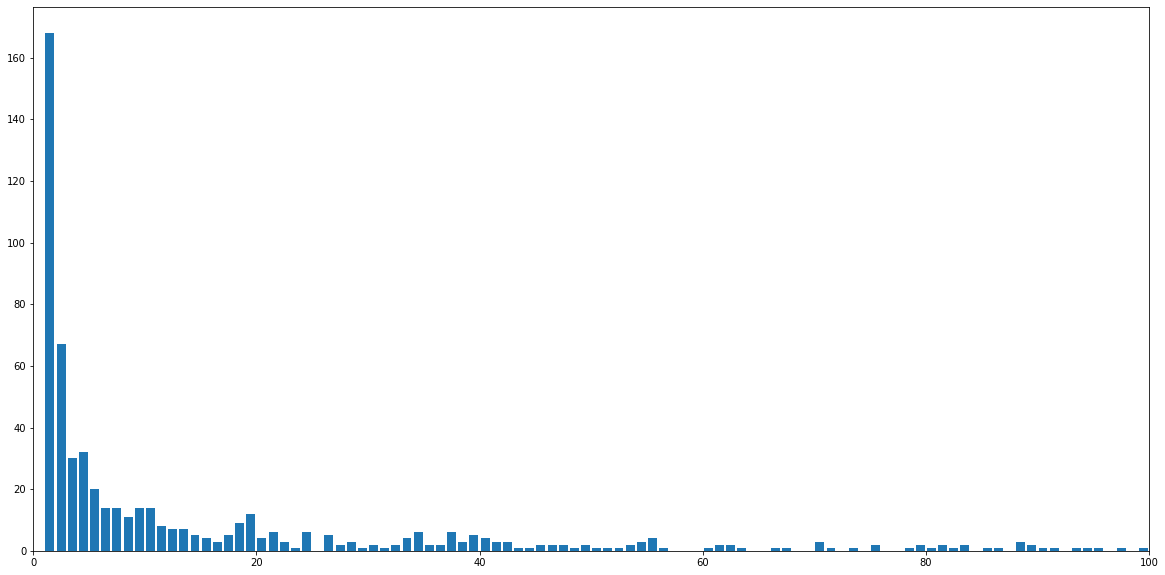

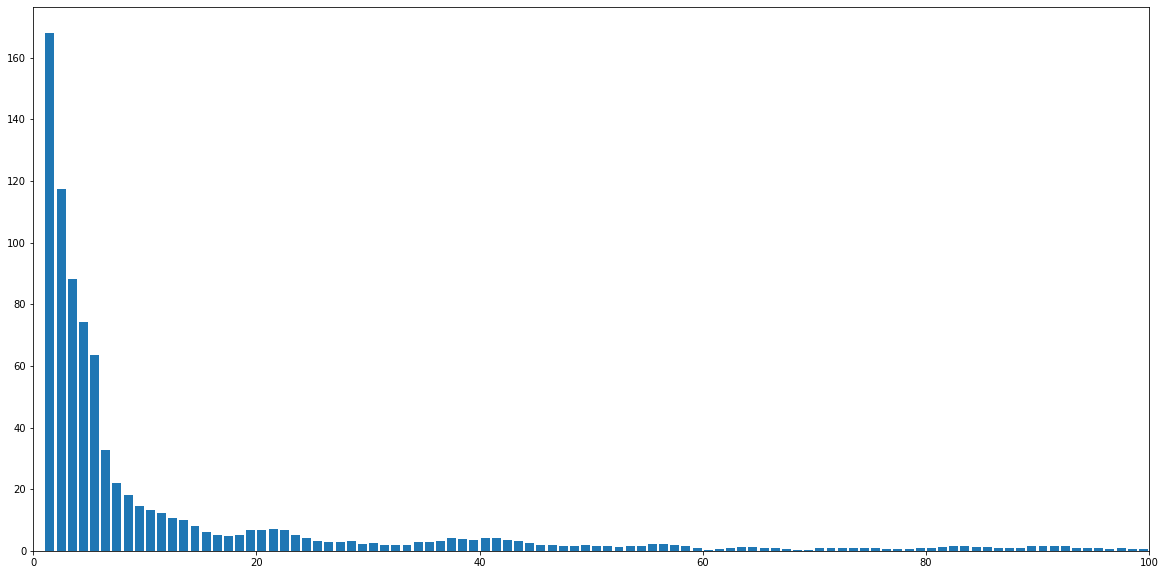

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

m = int(df["edits"].max())
counts, bins = np.histogram(df["edits"], bins=m)
xs = (bins[1:] + bins[:-1])/2

plt.bar(xs, counts)
plt.xlim(0,100)
plt.show()

import bottleneck as bn

ys = bn.move_mean(counts, window=5, min_count=1)
plt.bar(xs, ys)
plt.xlim(0,100)
plt.show()

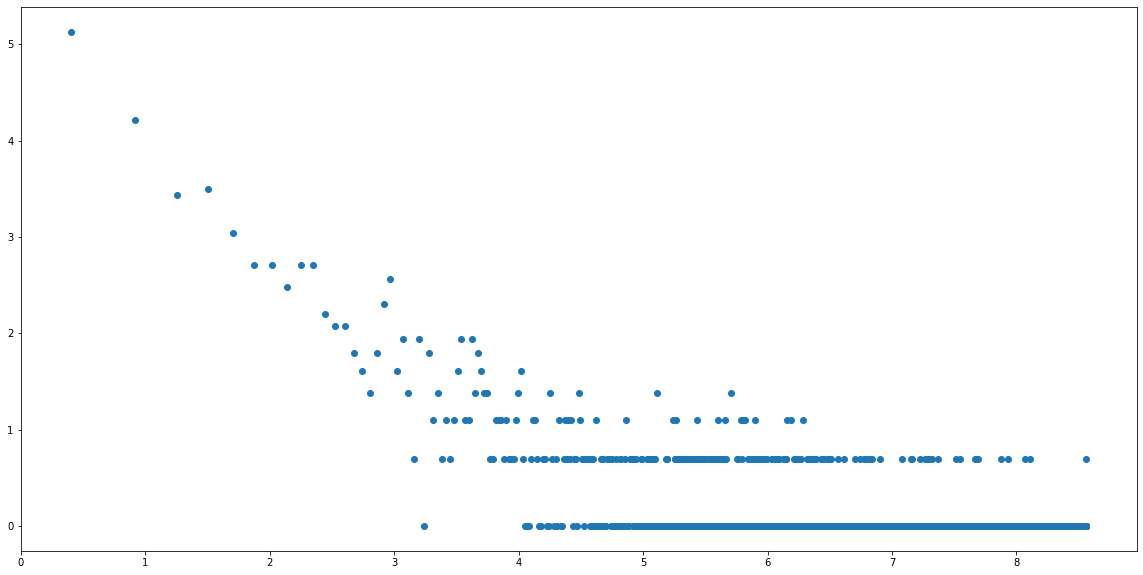

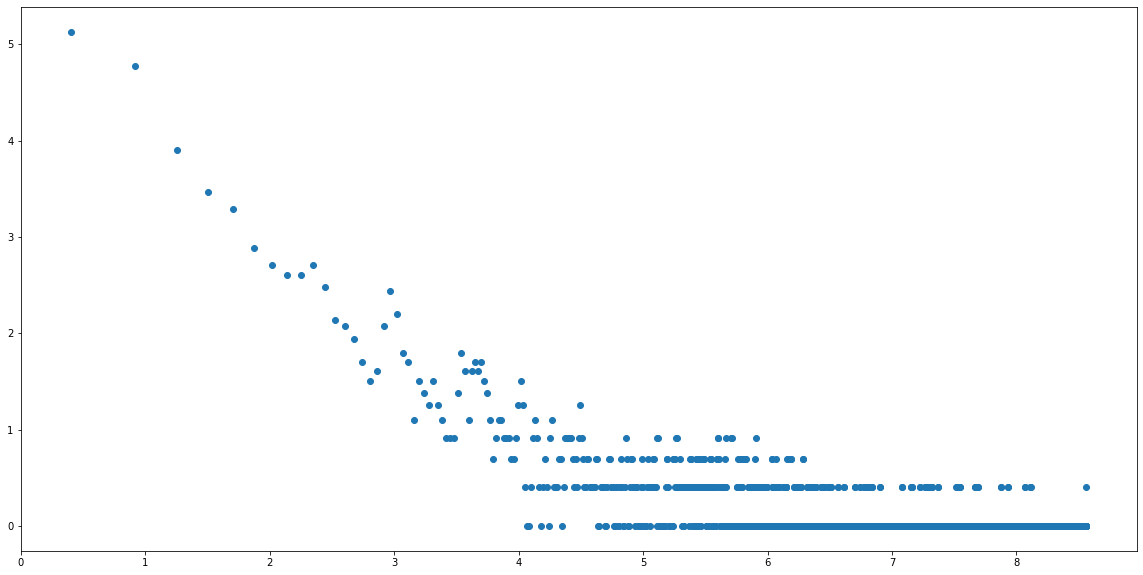

In [56]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

m = int(df["edits"].max())
counts, bins = np.histogram(df["edits"], bins=m)
xs = (bins[1:] + bins[:-1])/2

plt.plot(np.log(xs), np.log(counts + 1), "o")
plt.show()

import bottleneck as bn

ys = bn.move_mean(counts, window=2, min_count=1)
plt.plot(np.log(xs), np.log(ys+1), "o")
plt.show()

In [20]:
from scipy.stats import pareto

e = df["edits"]
params = pareto.fit(e[e > 1], floc=1)
print(params)

(0.3064856028589531, 1, 1)


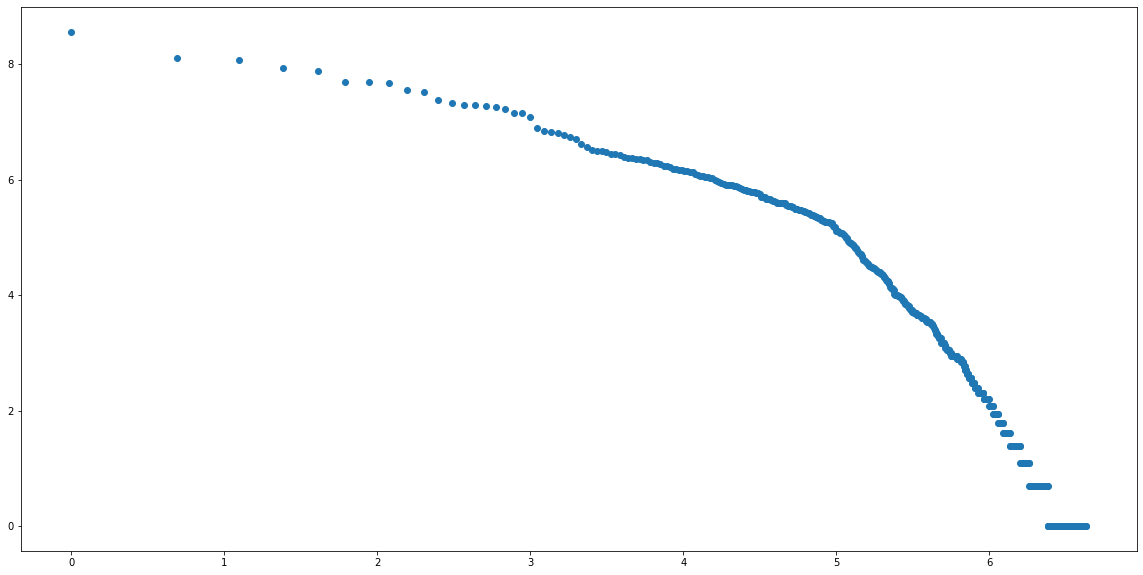

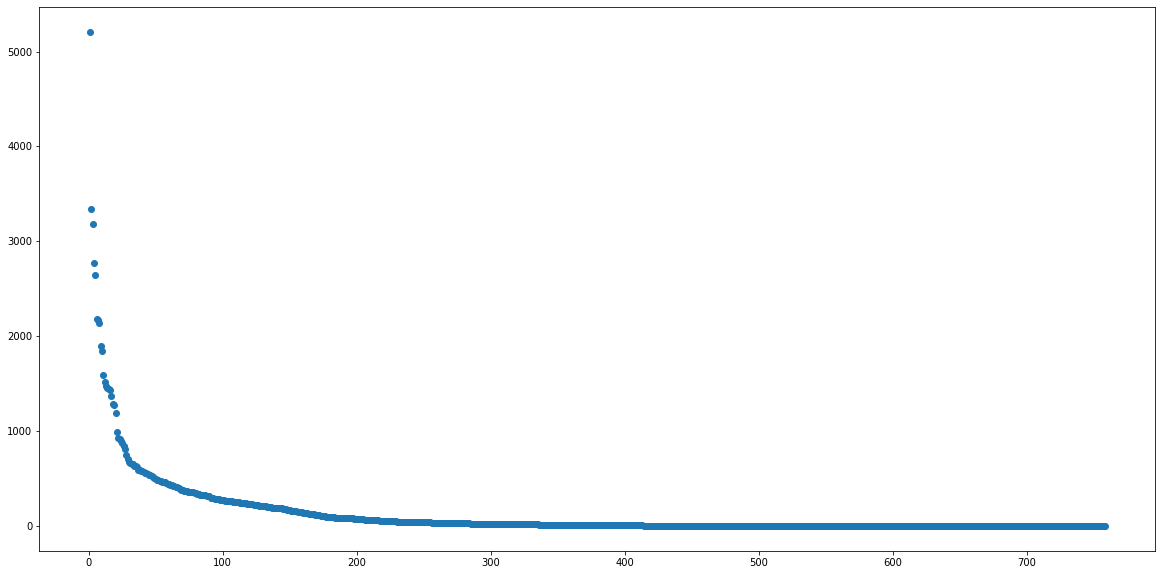

In [123]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

edits = df["edits"].copy()
edits.sort_values(inplace=True)
#display(edits)

ranks = scipy.stats.rankdata(edits, method="ordinal")
ranks = ranks.max()+1-ranks
#display(ranks)

plt.plot(np.log(ranks), np.log(edits), "o")
plt.show()

plt.plot(ranks, edits, "o")
plt.show()

https://en.wikipedia.org/wiki/File:Wikipedia-n-zipf.png

https://en.wikipedia.org/wiki/Yule%E2%80%93Simon_distribution

right params: [-3.29227601 21.82567281]
left params: [-0.53689817  8.65454849]


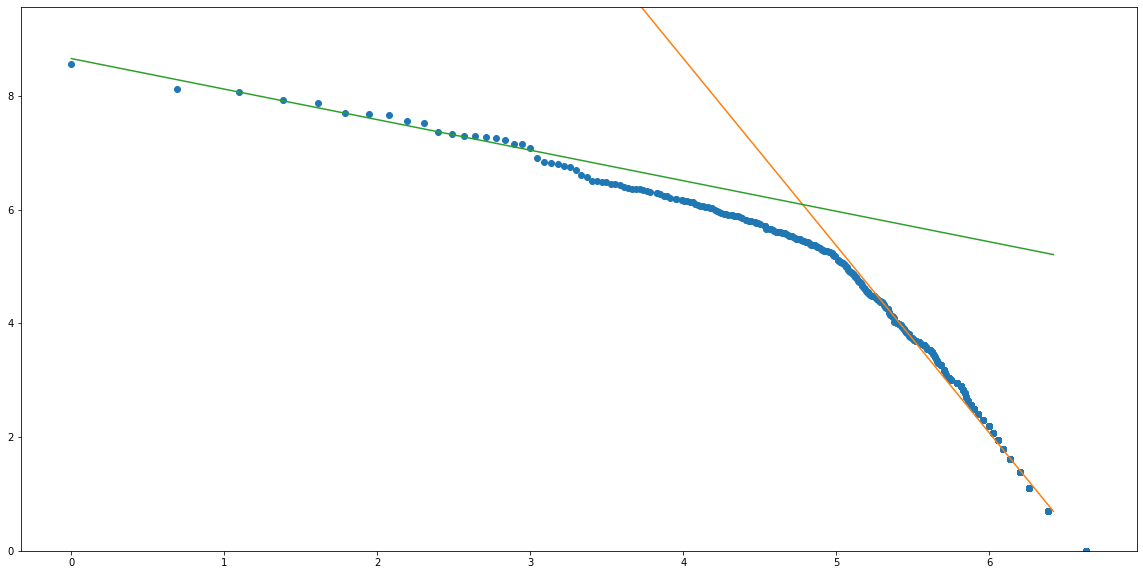

In [120]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

edits = df["edits"].copy()
edits.sort_values(inplace=True)
#display(edits)

ranks = scipy.stats.rankdata(edits, method="min")
ranks = ranks.max()+1-ranks
#display(ranks)

xs = np.log(ranks)
ys = np.log(edits)

xs1 = xs[:-140]
ys1 = ys[:-140]

plt.plot(xs, ys, "o")

params1 = np.polyfit(xs1, ys1, 1)
print("right params:", params1)

xs3 = np.linspace(0,ys.max(),5)[:4]
ys3 = params1[1]+params1[0]*xs3

plt.plot(xs3, ys3)

xs2 = xs[-25:]
ys2 = ys[-25:]
params2 = np.polyfit(xs2, ys2, 1)
print("left params:", params2)

plt.plot(xs3, params2[1]+params2[0]*xs3)

plt.ylim(0, ys.max()+1)
plt.show()

params: [-0.06478139  0.41143731 -1.23071963  8.82122854]


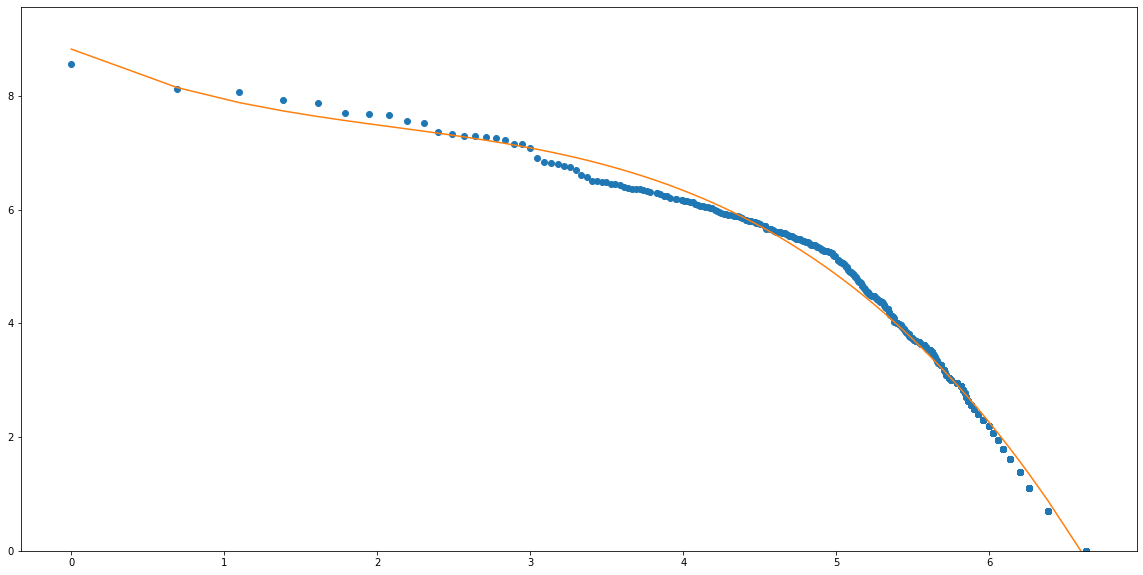

In [131]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

edits = df["edits"].copy()
edits.sort_values(inplace=True)
#display(edits)

ranks = scipy.stats.rankdata(edits, method="min")
ranks = ranks.max()+1-ranks
#display(ranks)

xs = np.log(ranks)
ys = np.log(edits)

xs1 = xs[:-140]
ys1 = ys[:-140]

plt.plot(xs, ys, "o")

params = np.polyfit(xs[:-1], ys[:-1], 3)
print("params:", params)

plt.plot(xs, params[3]+params[2]*xs+params[1]*xs**2+params[0]*xs**3)

plt.ylim(0, ys.max()+1)
plt.show()

# Rank-Plot: All data

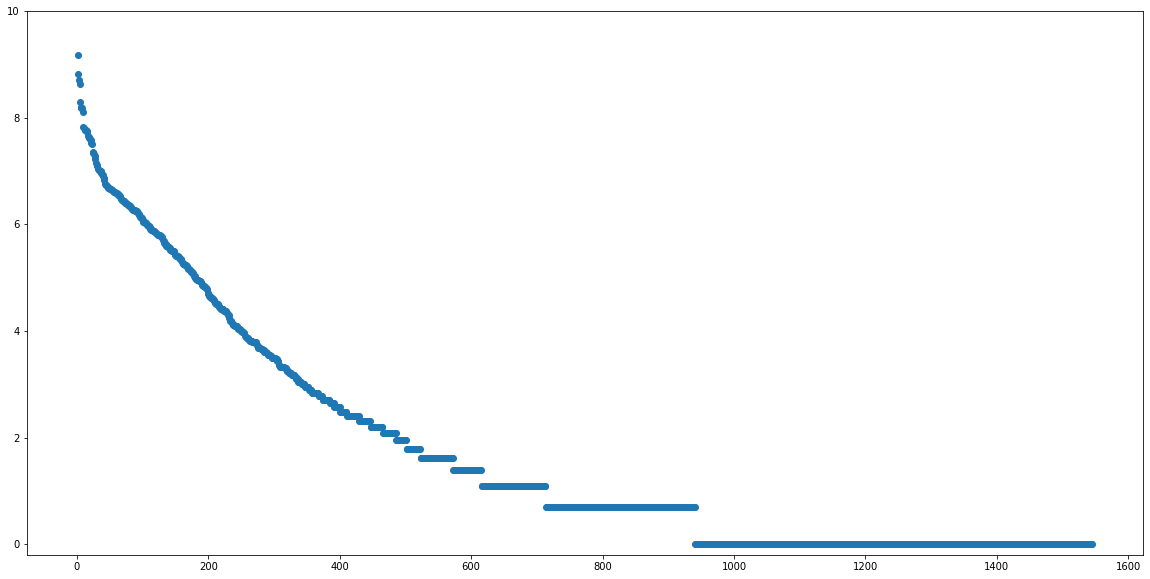

In [291]:
from IPython.display import Markdown

def rank_plot(df):
    xs, ys = compute_xs_ys(df)

    plt.plot(xs, ys, "o")
    plt.ylim(-0.2,10)
    plt.show()

    
def count_edits(times):
    if len(times) == 0:
        return 0
    
    diffs = times.diff().map(lambda x: x.total_seconds())
    
    return diffs[diffs > 5].count() + 1

def compute_xs_ys(df):
    df = df[df["username"] != "Legacy"]
    df = df.groupby("actor_id").aggregate({
        "date": count_edits,
    })
    edits = df["date"].copy()
    edits.sort_values(inplace=True)

    ranks = scipy.stats.rankdata(edits, method="ordinal")
    ranks = ranks.max()+1-ranks

    return (ranks, np.log(edits))

display(Markdown("# Rank-Plot: All data"))
rank_plot(event_log)

# Rank plot with delta_days=90

## Plot: Last 90 days

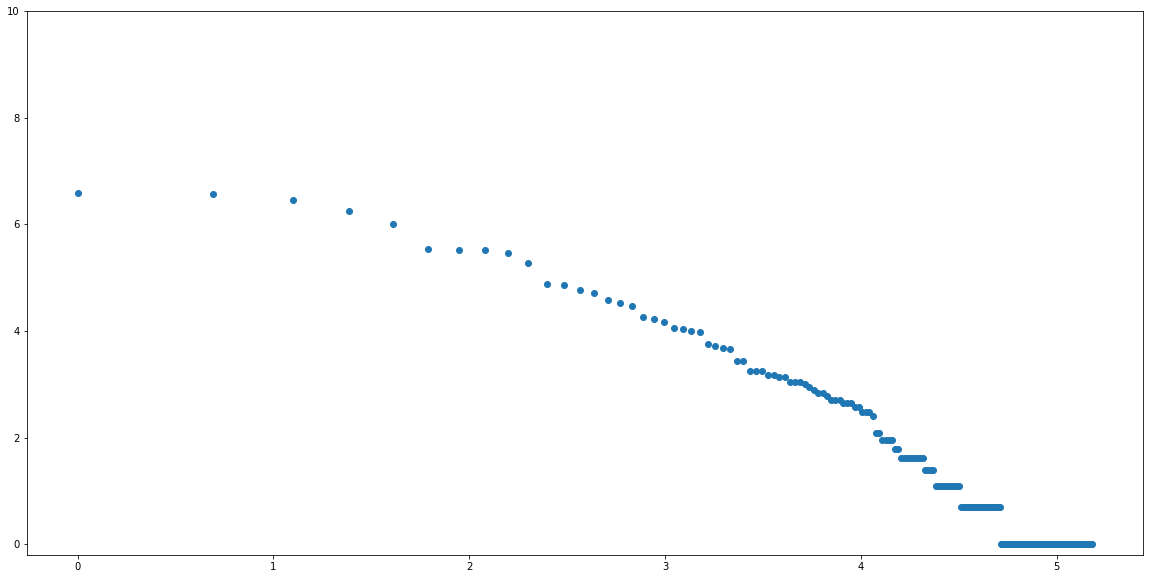

## Plot: Last 180-90 days

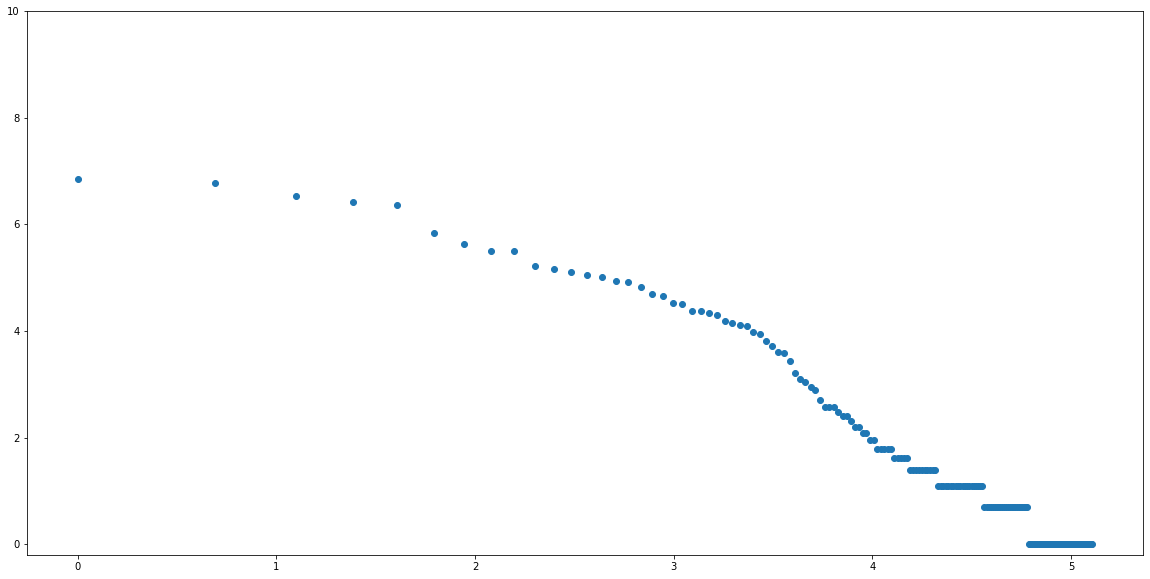

# Rank plot with delta_days=182

## Plot: Last 182 days

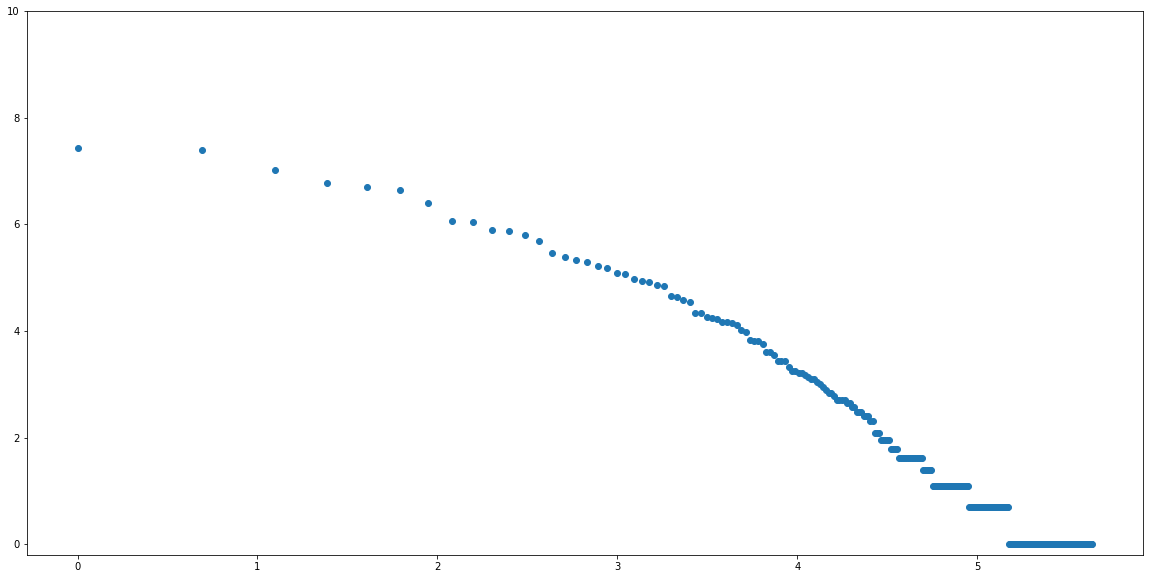

## Plot: Last 364-182 days

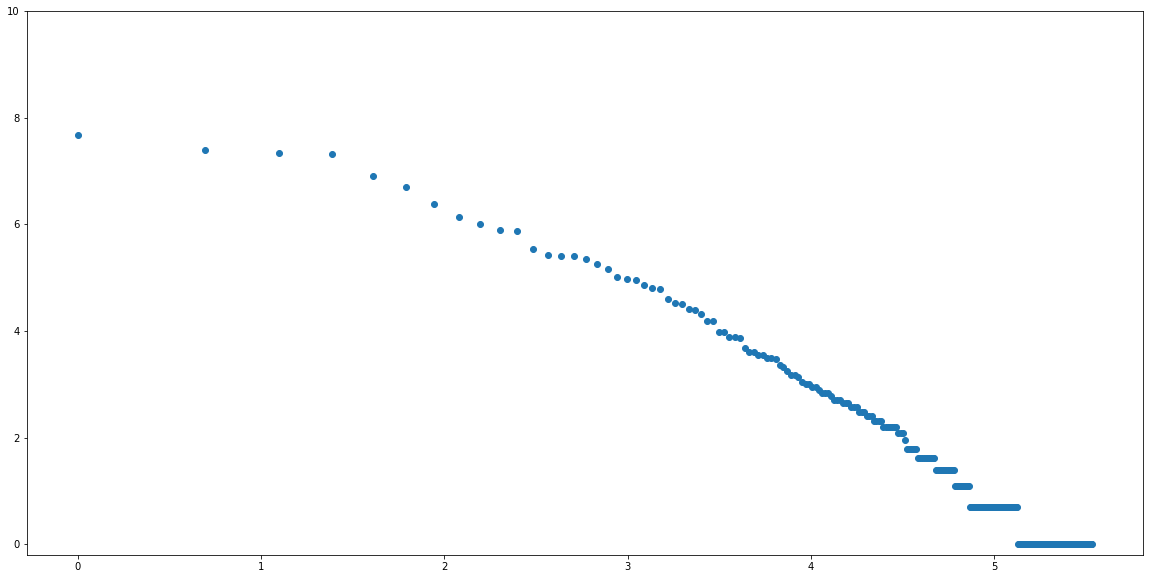

# Rank plot with delta_days=365

## Plot: Last 365 days

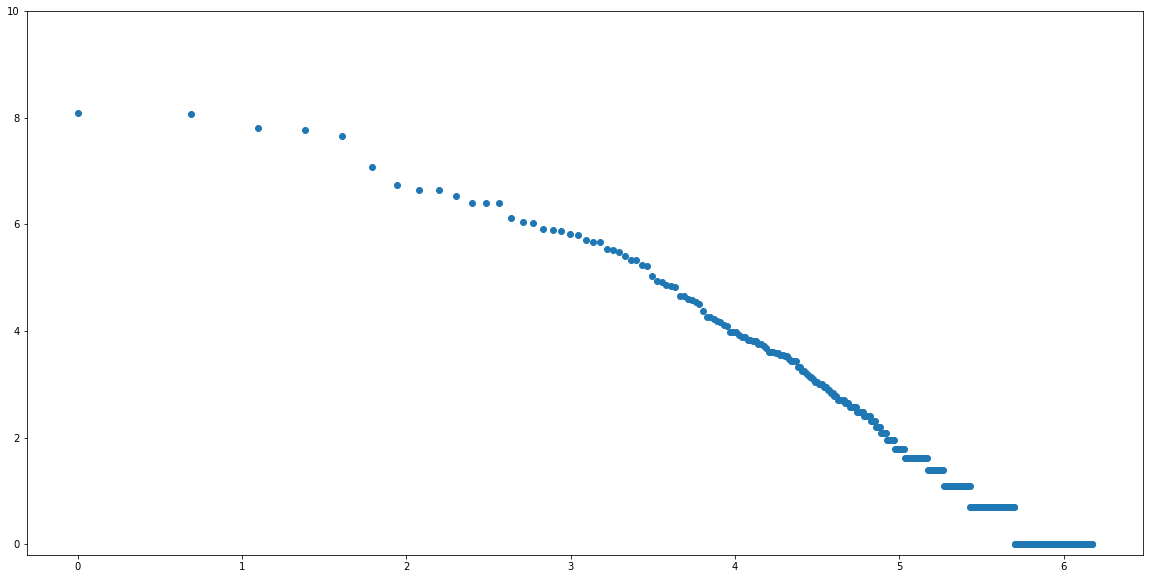

## Plot: Last 730-365 days

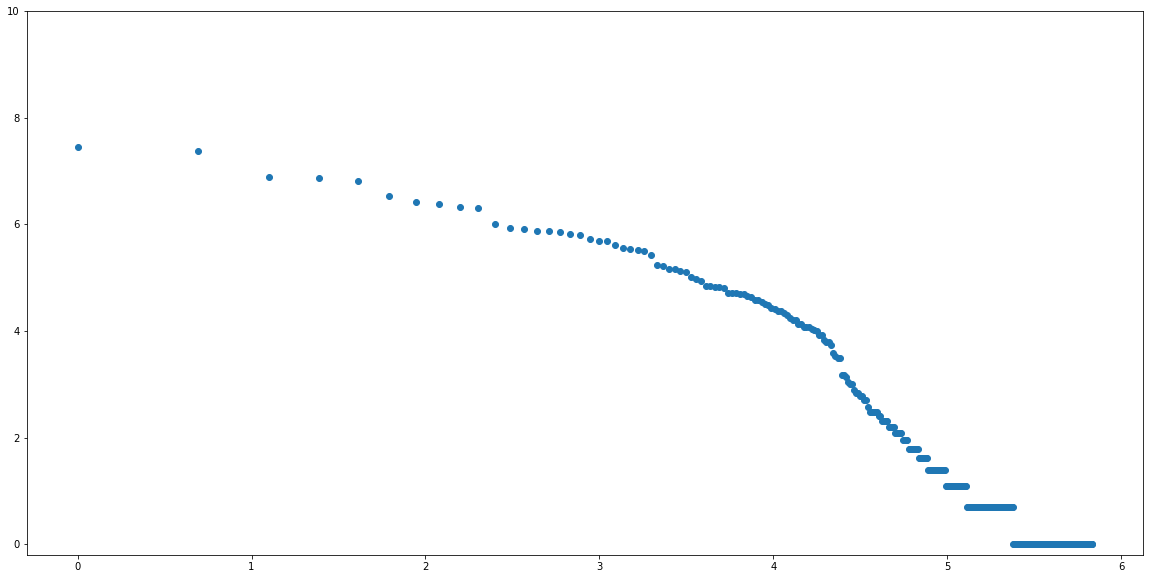

# Rank plot with delta_days=730

## Plot: Last 730 days

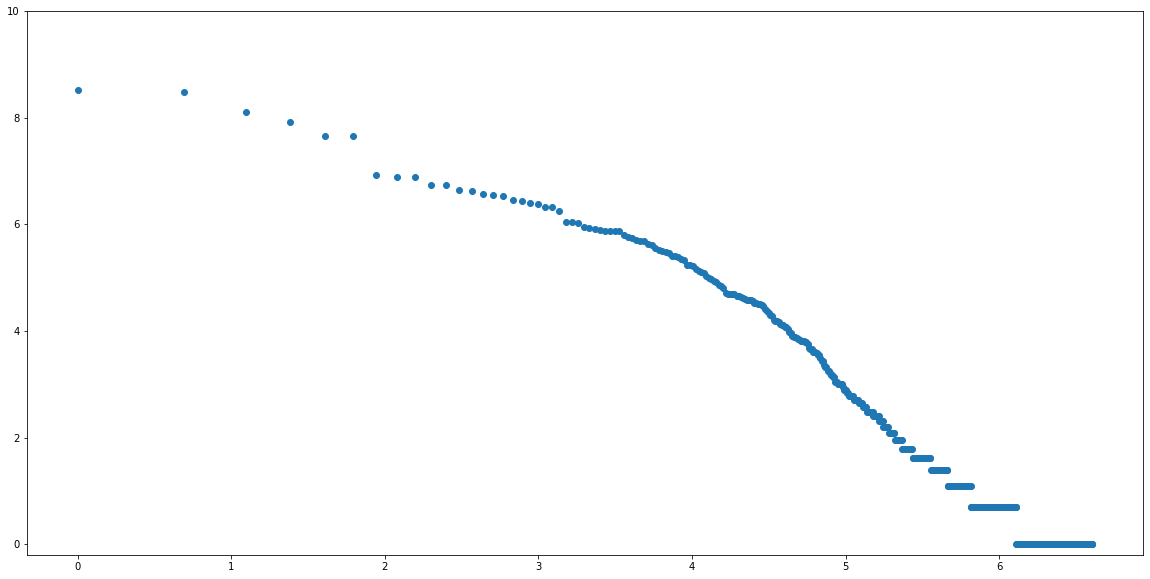

## Plot: Last 1460-730 days

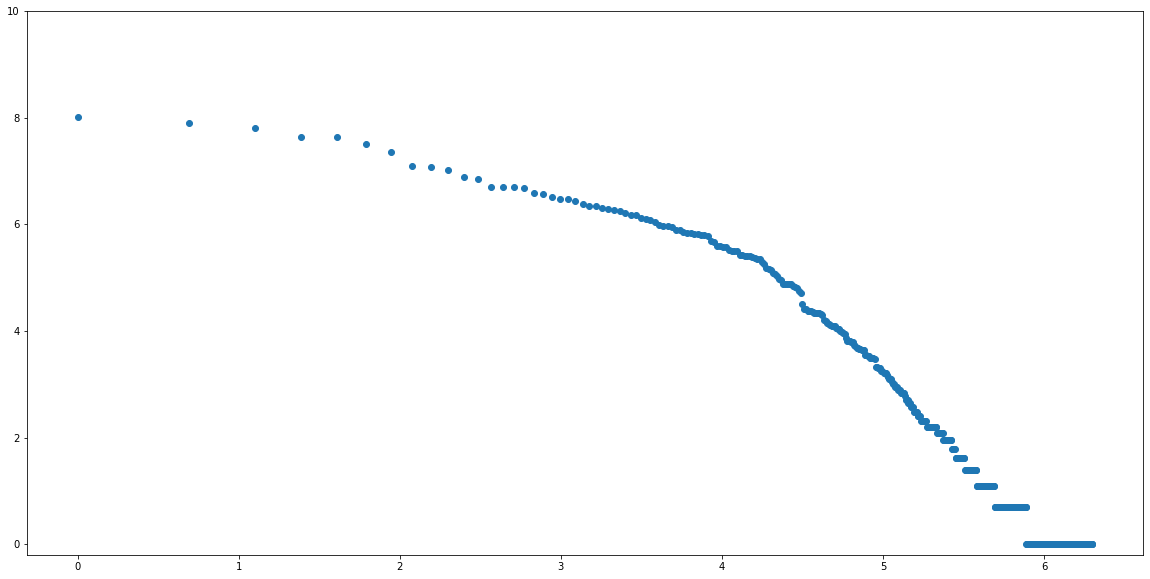

In [168]:
def plot_delta(df, delta_days):
    display(Markdown(f"# Rank plot with delta_days={delta_days}"))
    
    display(Markdown(f"## Plot: Last {delta_days} days"))
    rank_plot(event_log[event_log["date"] >= event_log["date"].max() - pd.Timedelta(days=delta)])    
    
    display(Markdown(f"## Plot: Last {2*delta_days}-{delta_days} days"))
    a = event_log["date"] >= event_log["date"].max() - pd.Timedelta(days=2*delta)
    b = event_log["date"] < event_log["date"].max() - pd.Timedelta(days=delta)
    rank_plot(event_log[a & b])

for delta in [90, 182, 365, 730]:
    plot_delta(event_log, delta)

# Rank plot with delta_days=90

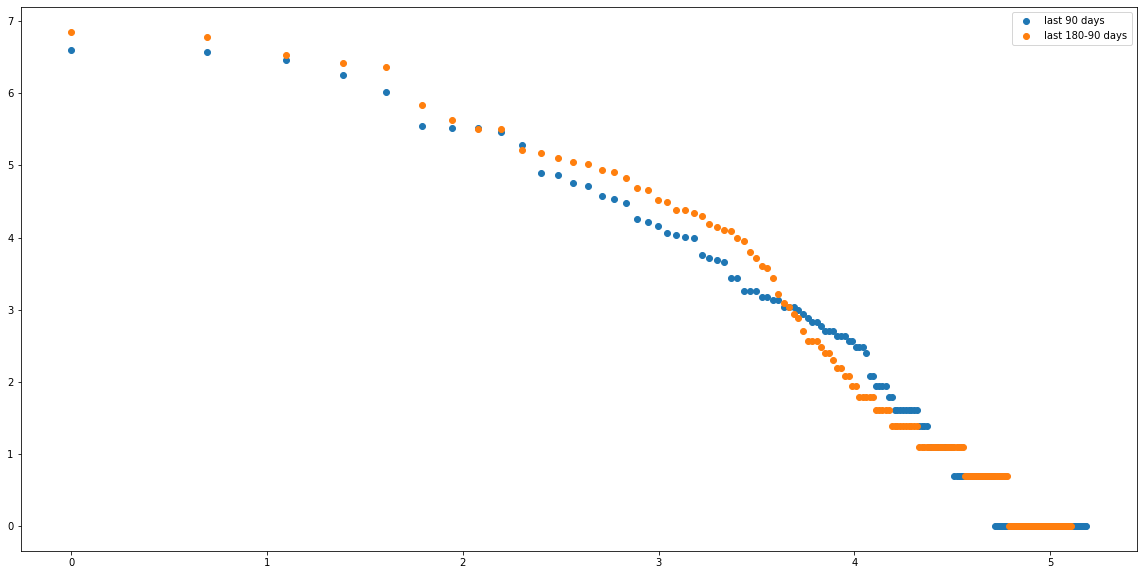

# Rank plot with delta_days=182

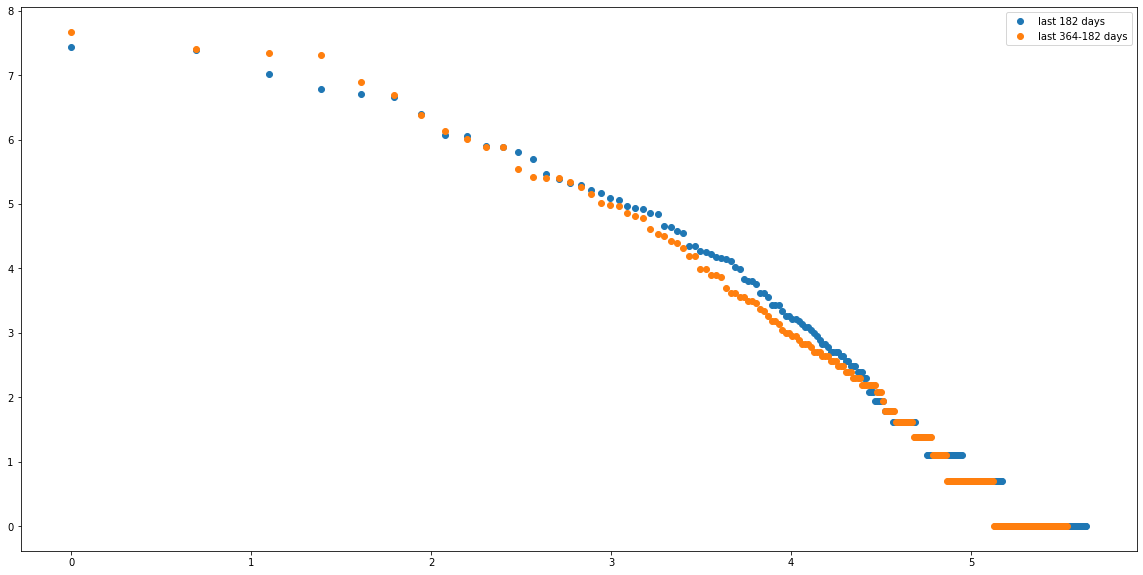

# Rank plot with delta_days=365

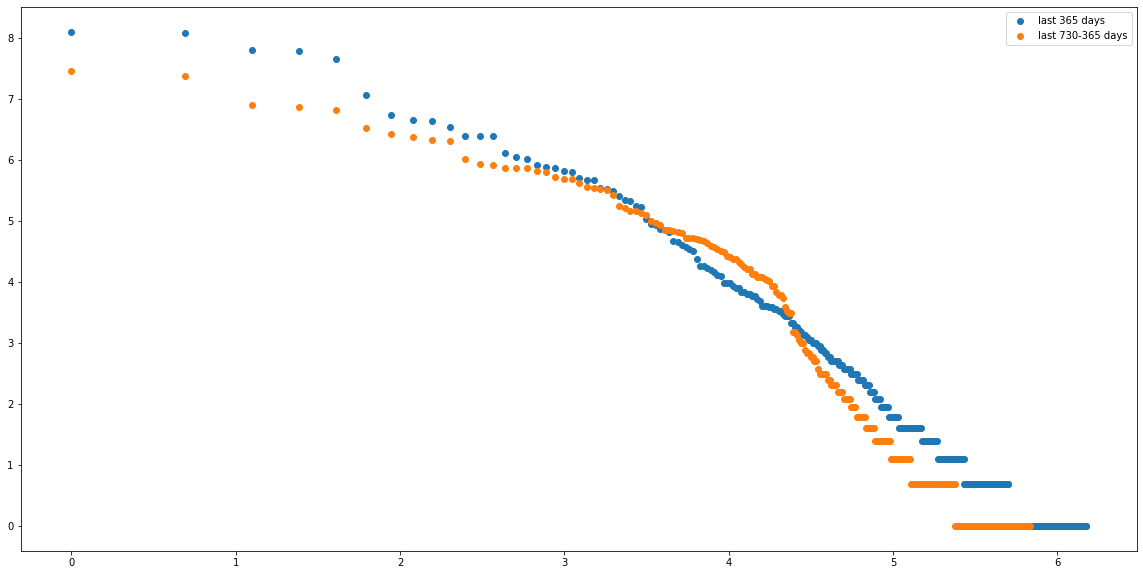

# Rank plot with delta_days=730

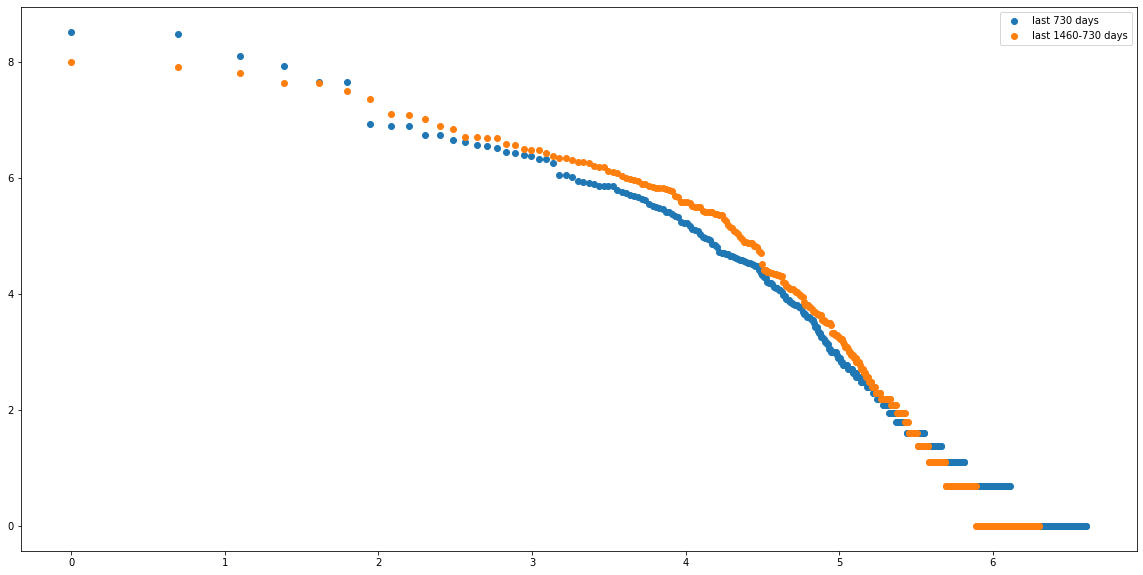

In [174]:
def plot_delta2(df, delta_days):
    display(Markdown(f"# Rank plot with delta_days={delta_days}"))
    
    time_plot(event_log[event_log["date"] >= event_log["date"].max() - pd.Timedelta(days=delta)],
             f"last {delta_days} days")
    
    a = event_log["date"] >= event_log["date"].max() - pd.Timedelta(days=2*delta)
    b = event_log["date"] < event_log["date"].max() - pd.Timedelta(days=delta)
    time_plot(event_log[a & b], f"last {2*delta_days}-{delta_days} days")
    
    plt.legend()
    plt.show()

def time_plot(df, label):
    xs, ys = compute_xs_ys(df)
    plt.plot(xs, ys, "o", label=label)

for delta in [90, 182, 365, 730]:
    plot_delta2(event_log, delta)

```
+----+-----------------------------+-------------+
| id | name                        | description |
+----+-----------------------------+-------------+
|  1 | taxonomy/term/associate     | NULL        |
|  2 | taxonomy/term/create        | NULL        |
|  3 | license/object/set          | NULL        |
|  4 | entity/create               | NULL        |
|  5 | entity/revision/add         | NULL        |
|  6 | entity/revision/checkout    | NULL        |
|  7 | entity/link/create          | NULL        |
|  8 | discussion/create           | NULL        |
|  9 | discussion/comment/create   | NULL        |
| 10 | uuid/trash                  | NULL        |
| 11 | entity/revision/reject      | NULL        |
| 12 | taxonomy/term/update        | NULL        |
| 13 | uuid/restore                | NULL        |
| 14 | discussion/comment/archive  | NULL        |
| 15 | taxonomy/term/parent/change | NULL        |
| 16 | discussion/restore          | NULL        |
| 17 | taxonomy/term/dissociate    | NULL        |
| 18 | entity/link/remove          | NULL        |
+----+-----------------------------+-------------+
```

# Rank-Plot: Inhaltsbearbeitungen

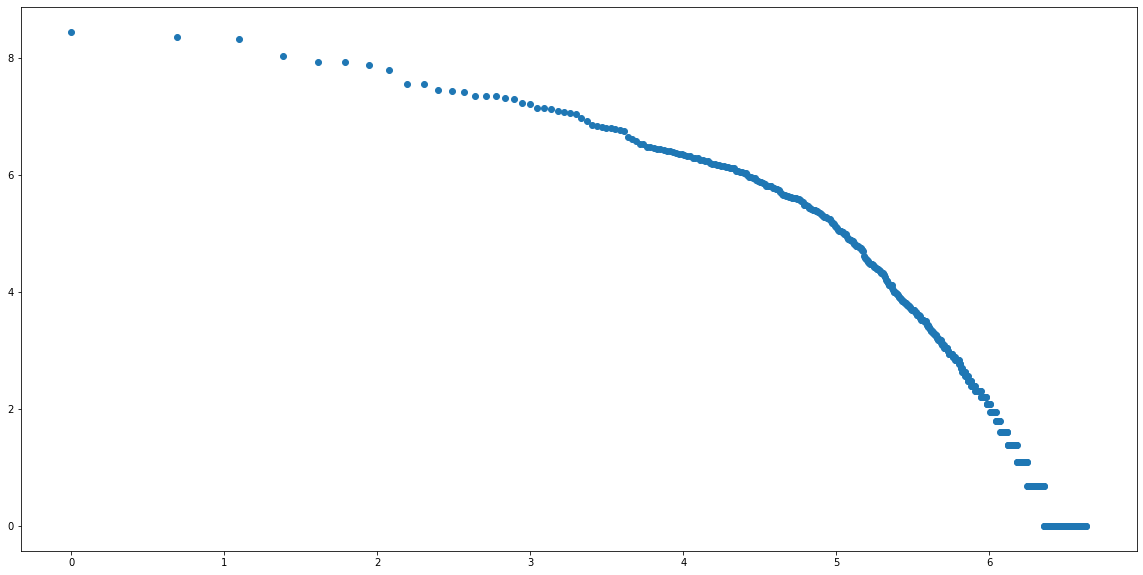

# Rank-Plot: Kommentare

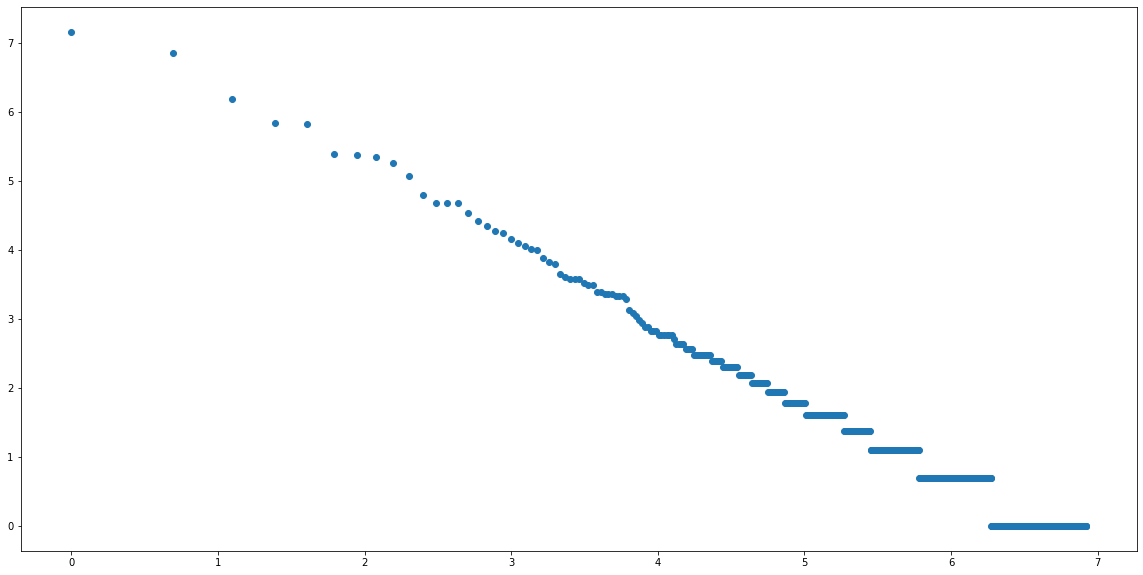

# Rank-Plot: Reviewing

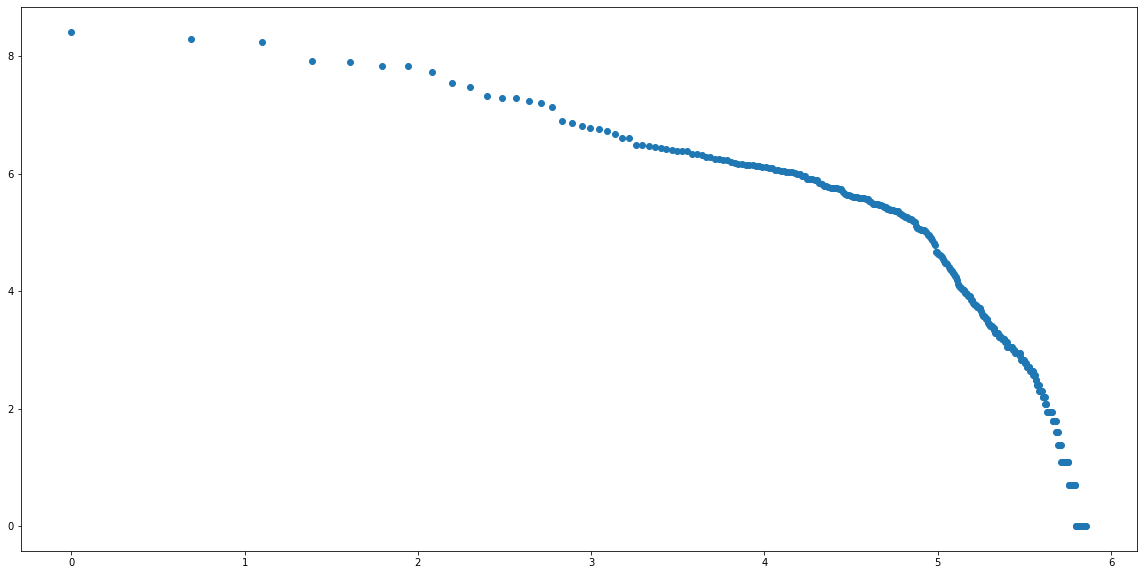

# Rank-Plot: Taxonomy

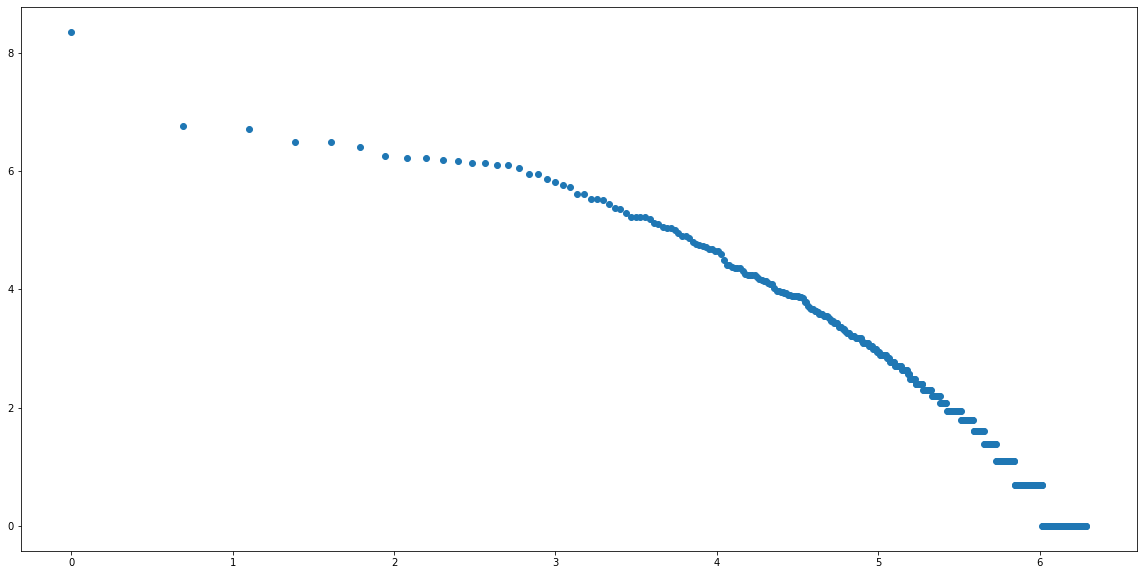

# Rank-Plot: Administratives

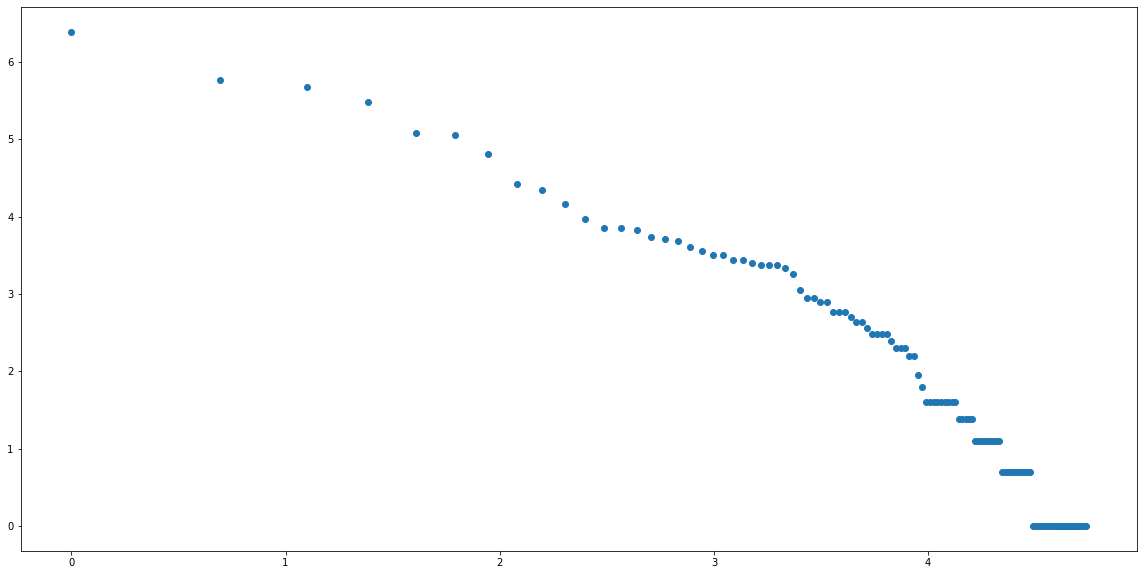

In [161]:
event_types = {
    "Inhaltsbearbeitungen": [5,6],
    "Kommentare": [8,9,14,16],
    "Reviewing": [6,11],
    "Taxonomy": [1,2,12,15,17],
    "Administratives": [10,13]
}

for event_type, event_ids in event_types.items():
    display(Markdown(f"# Rank-Plot: {event_type}"))
    rank_plot(event_log[event_log["event_id"].isin(event_ids)])

# Event-Type: Inhaltsbearbeitungen

# Rank plot with delta_days=90

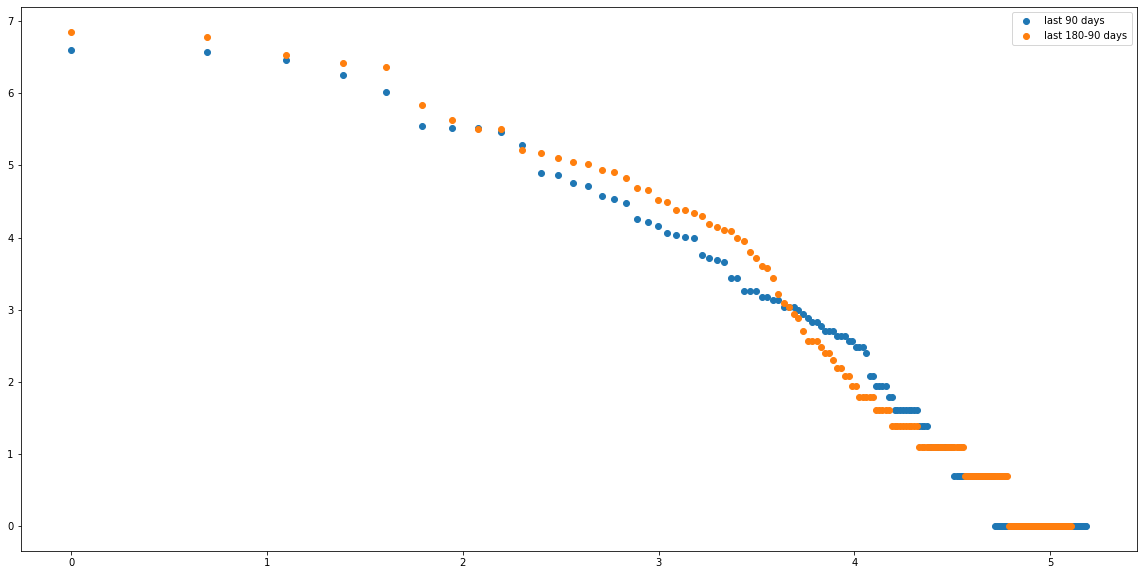

# Rank plot with delta_days=182

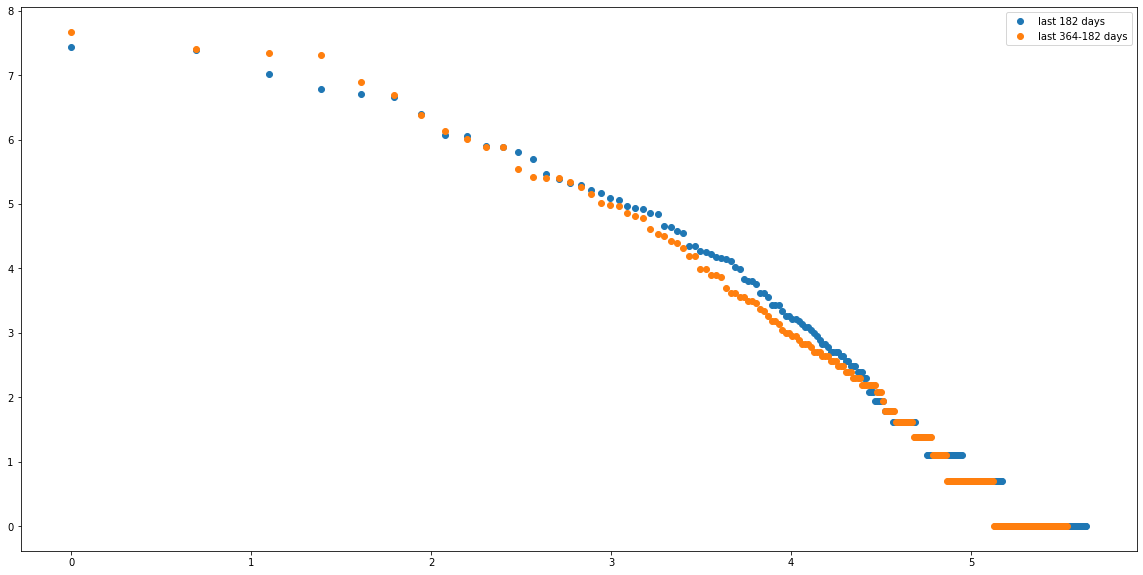

# Rank plot with delta_days=365

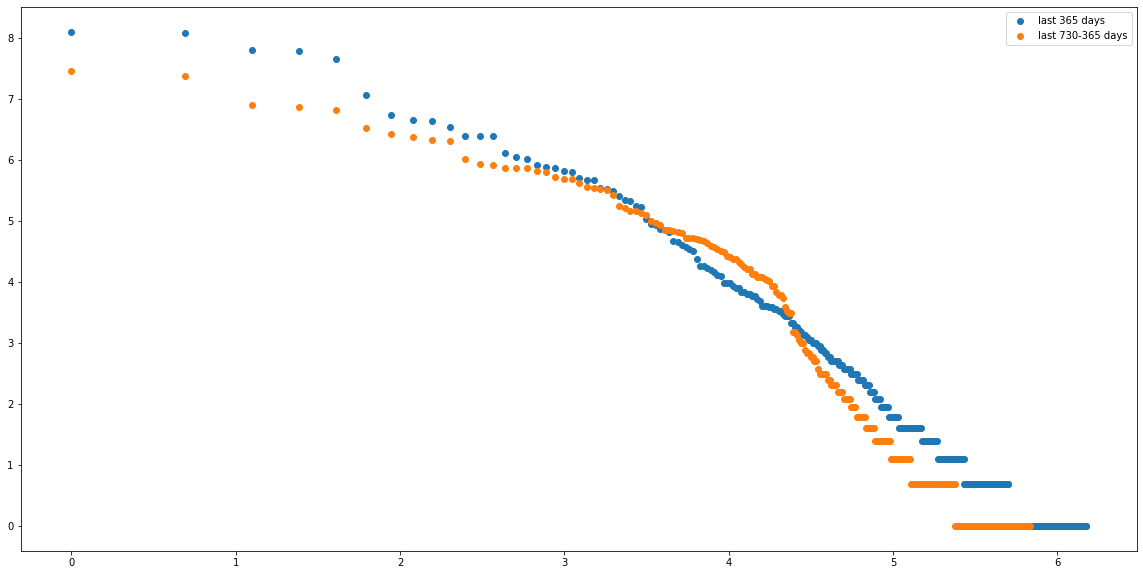

# Rank plot with delta_days=730

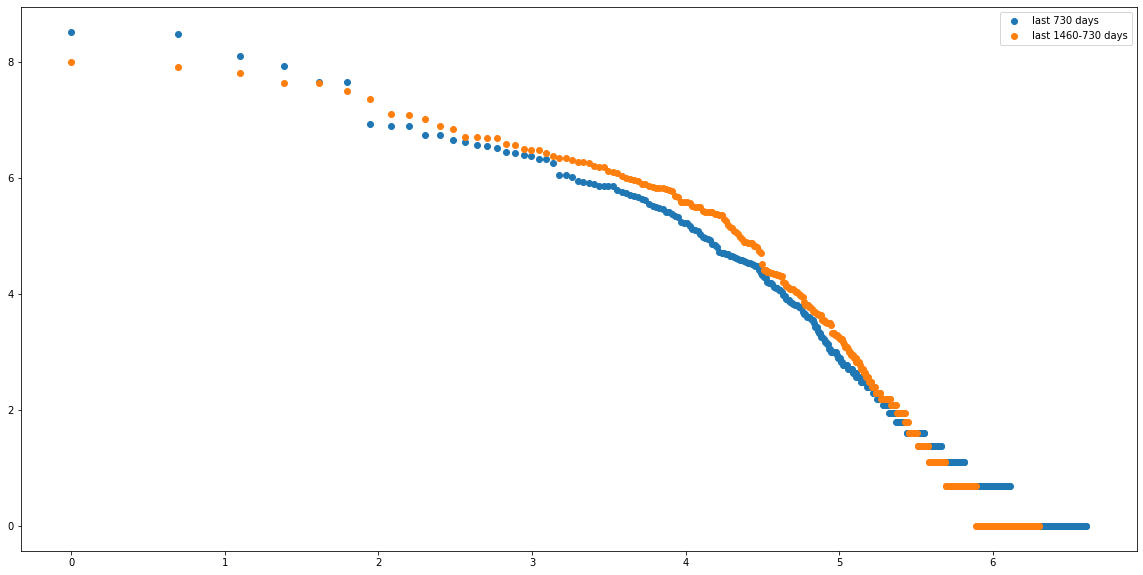

# Event-Type: Kommentare

# Rank plot with delta_days=90

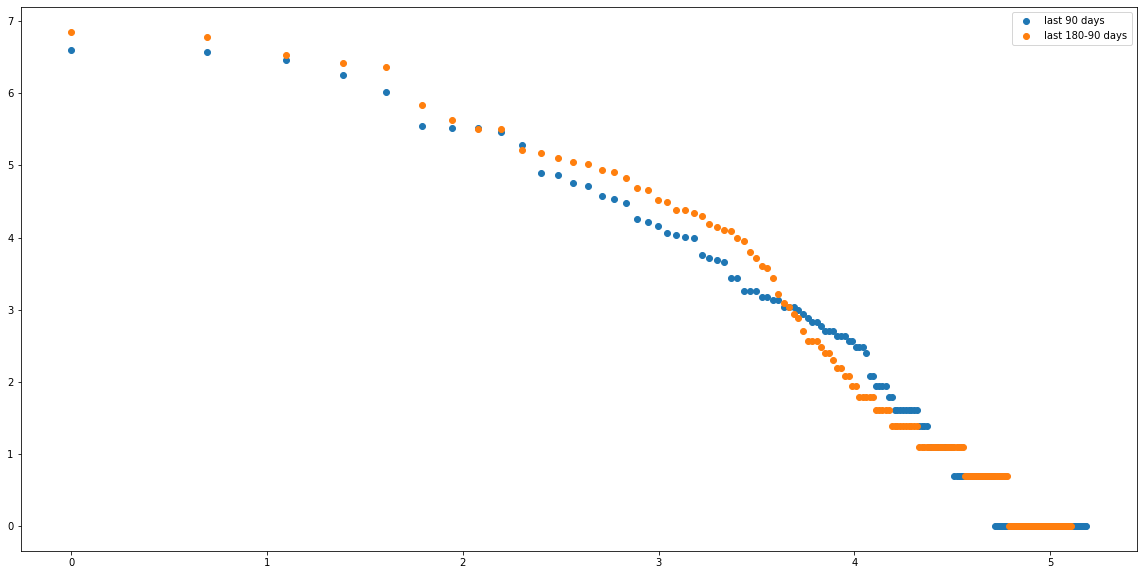

# Rank plot with delta_days=182

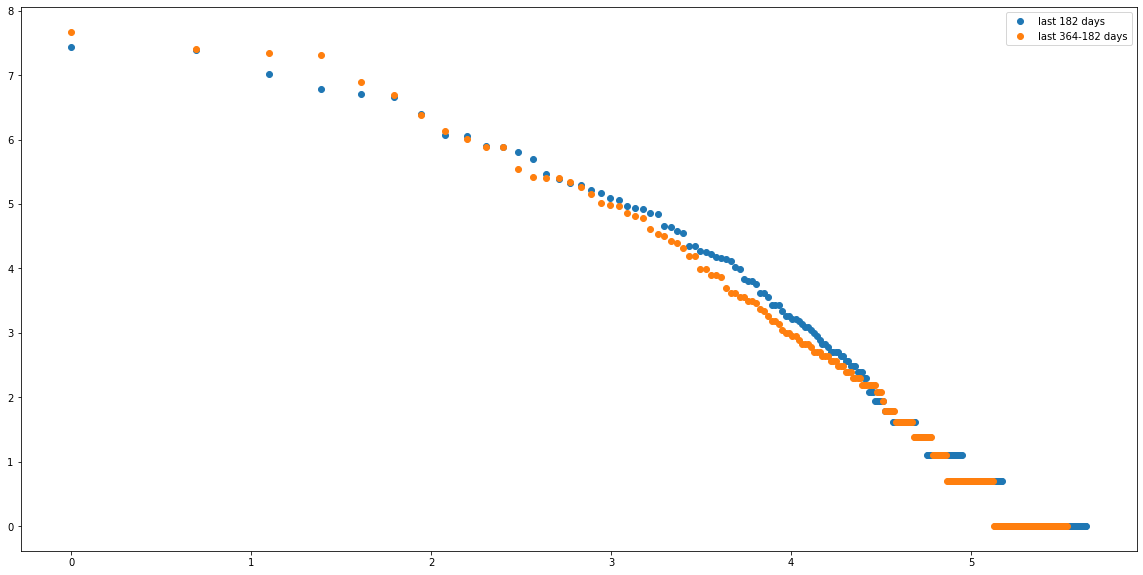

# Rank plot with delta_days=365

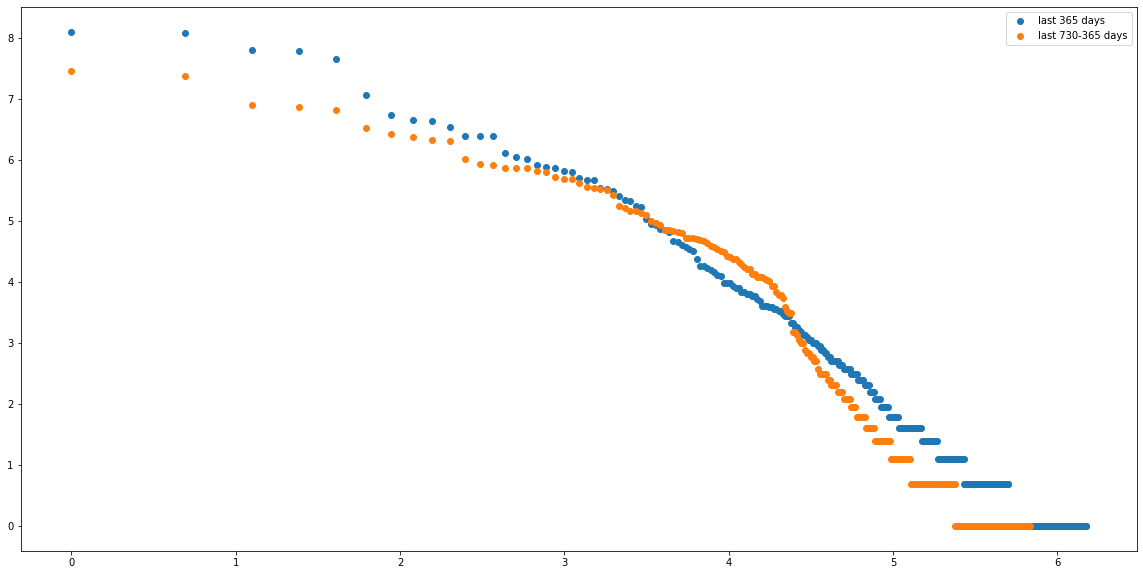

# Rank plot with delta_days=730

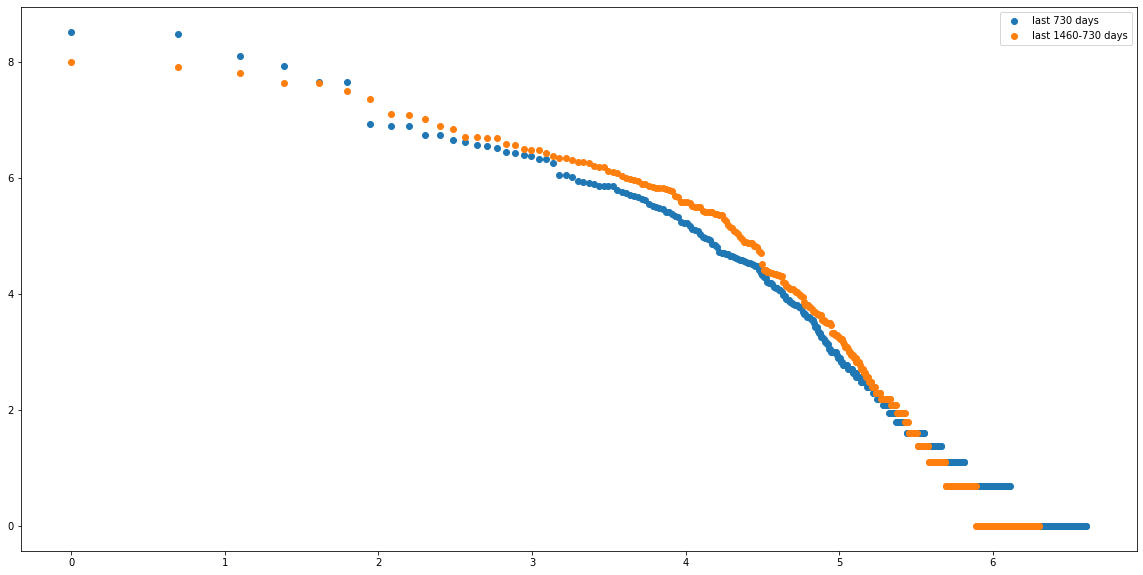

# Event-Type: Reviewing

# Rank plot with delta_days=90

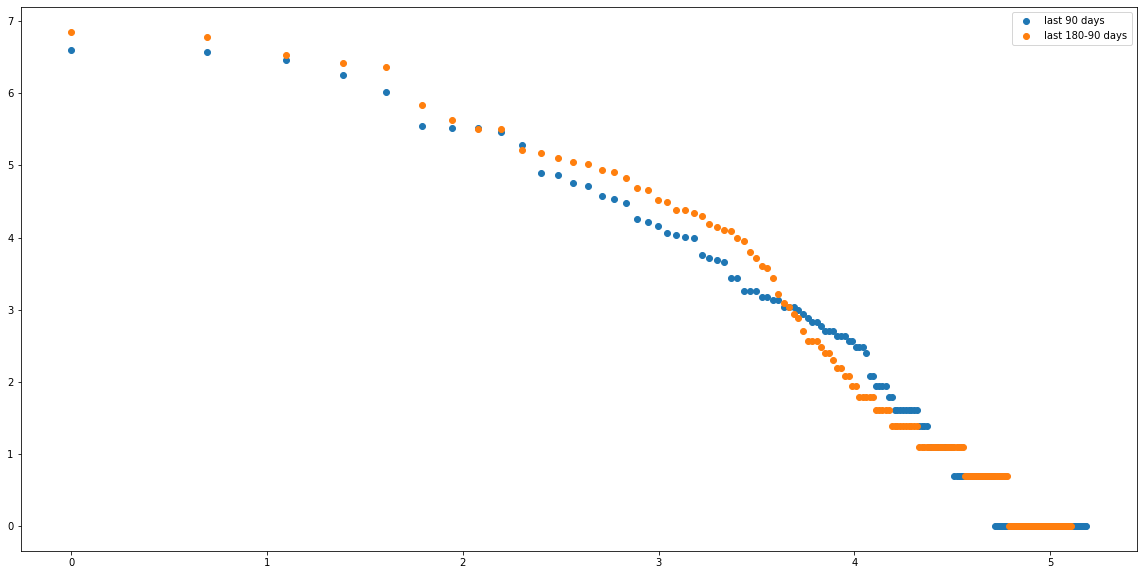

# Rank plot with delta_days=182

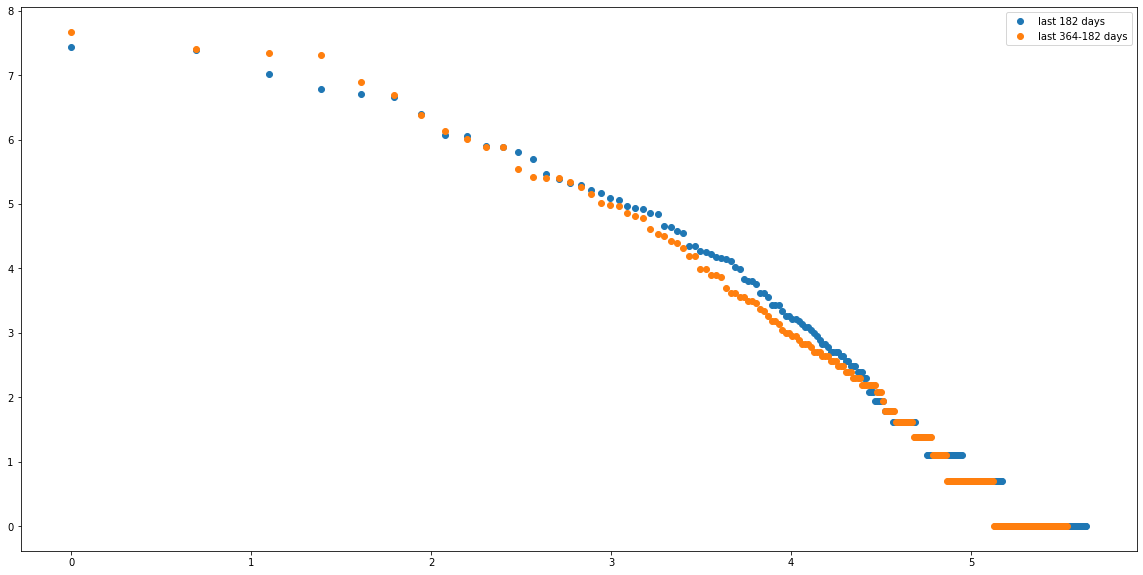

# Rank plot with delta_days=365

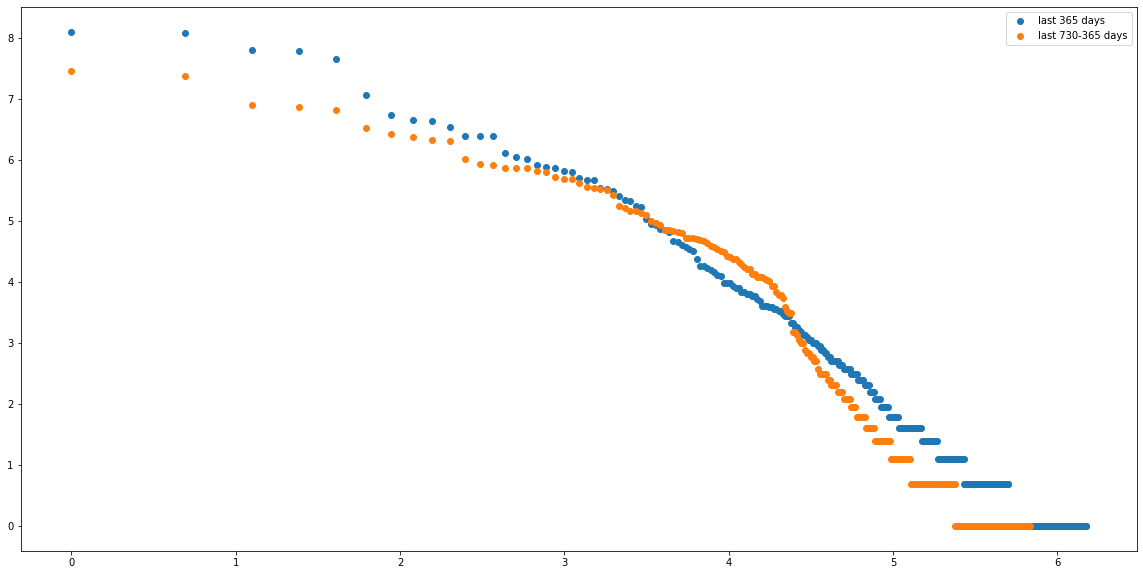

# Rank plot with delta_days=730

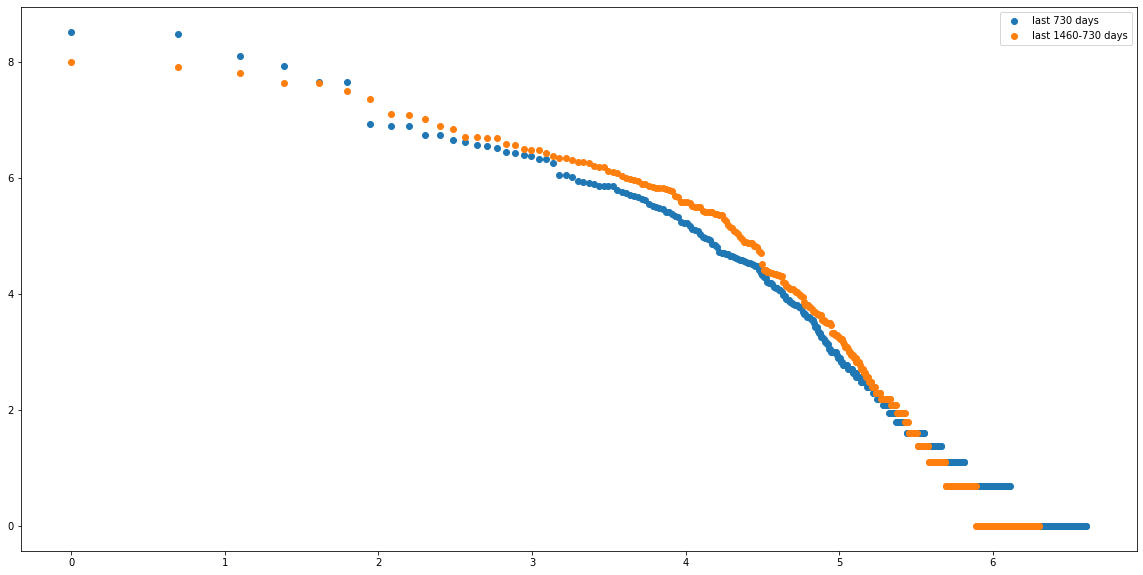

# Event-Type: Taxonomy

# Rank plot with delta_days=90

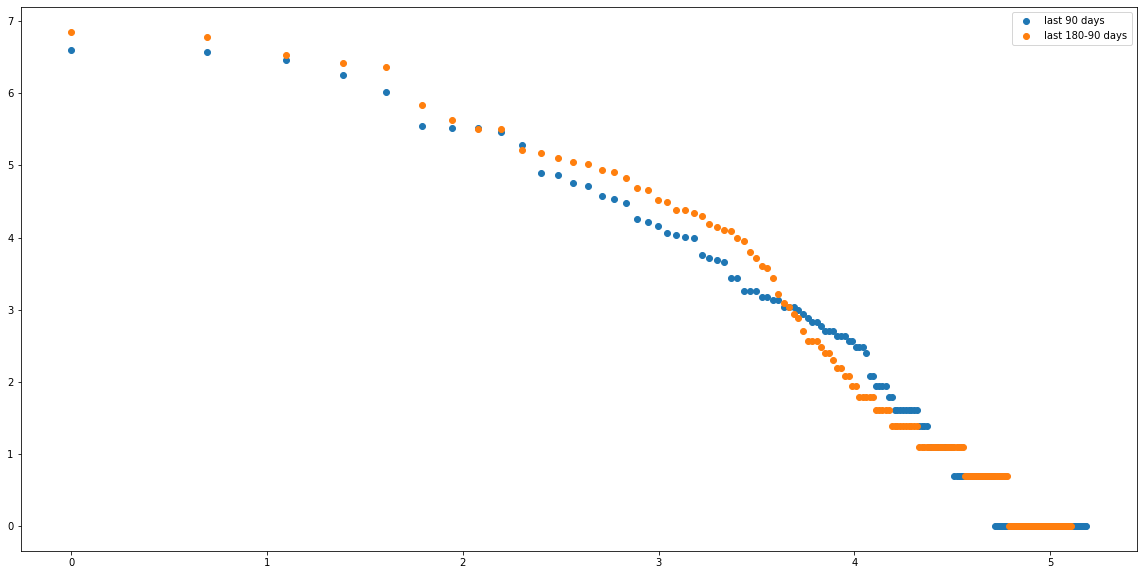

# Rank plot with delta_days=182

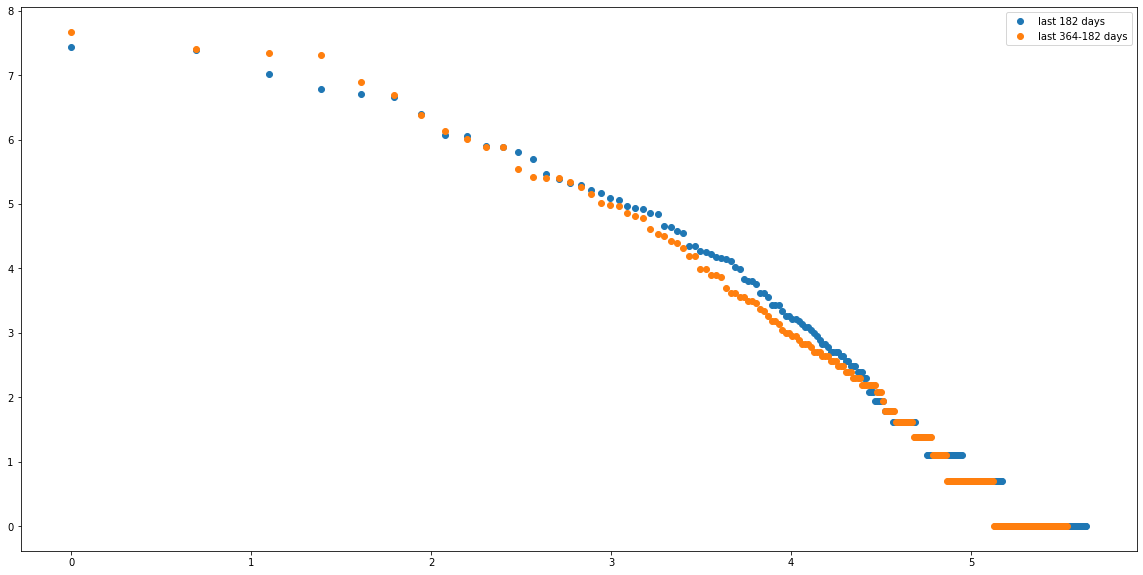

# Rank plot with delta_days=365

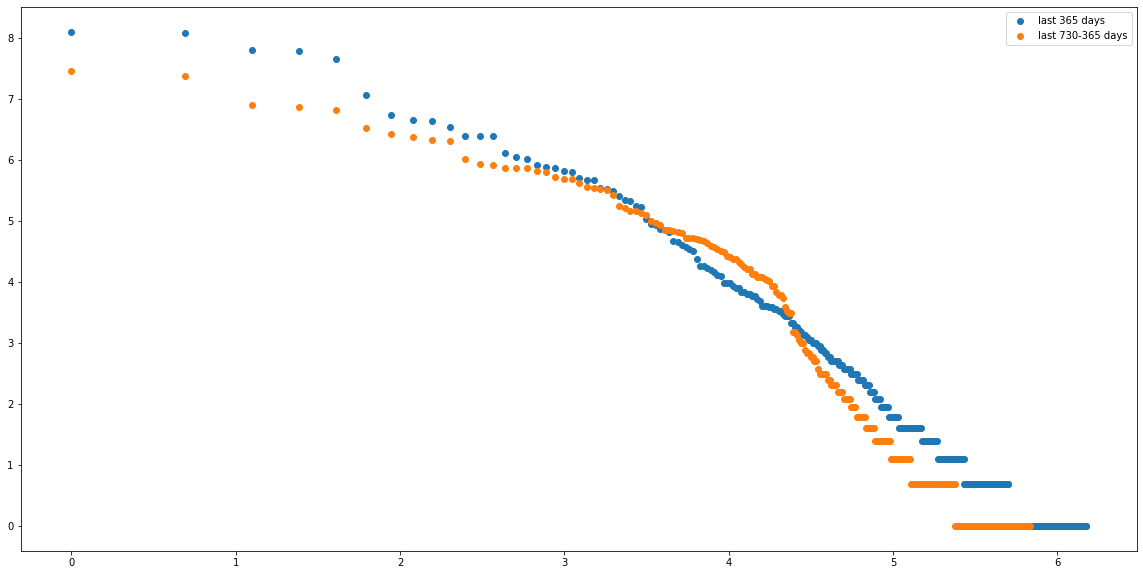

# Rank plot with delta_days=730

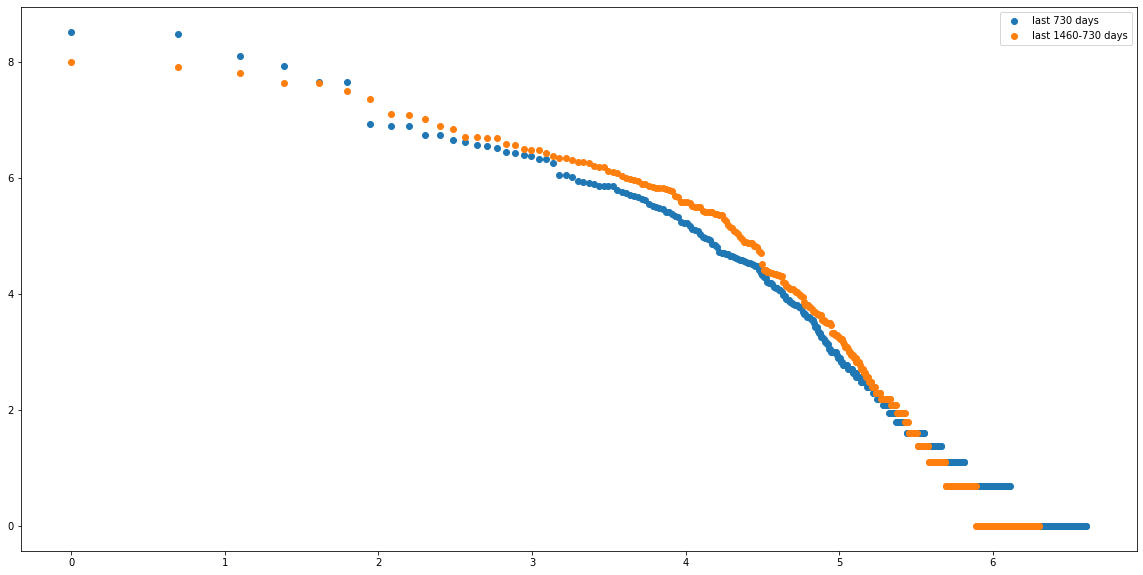

# Event-Type: Administratives

# Rank plot with delta_days=90

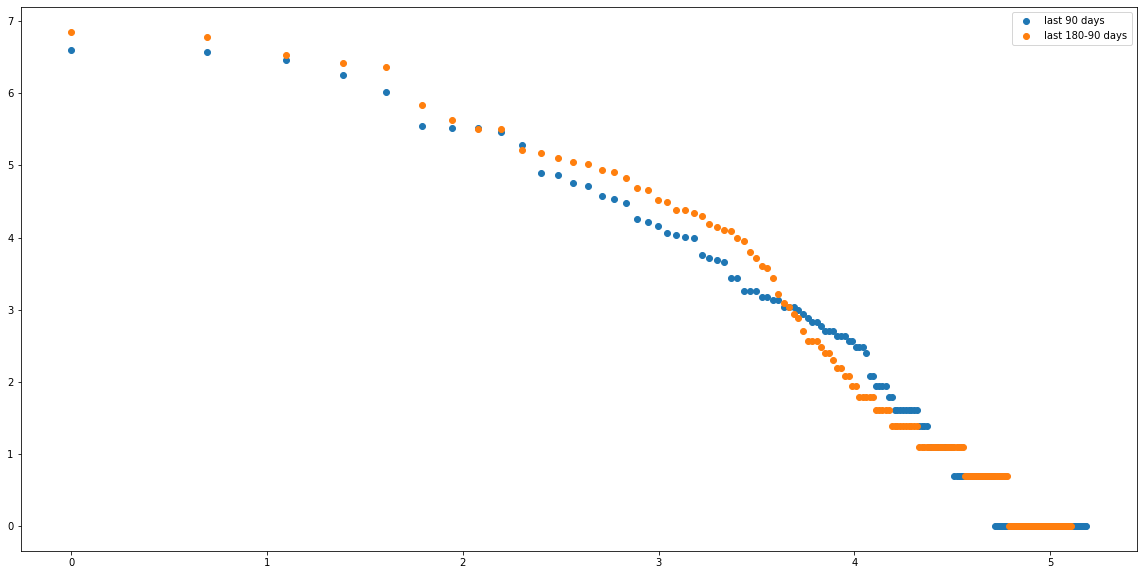

# Rank plot with delta_days=182

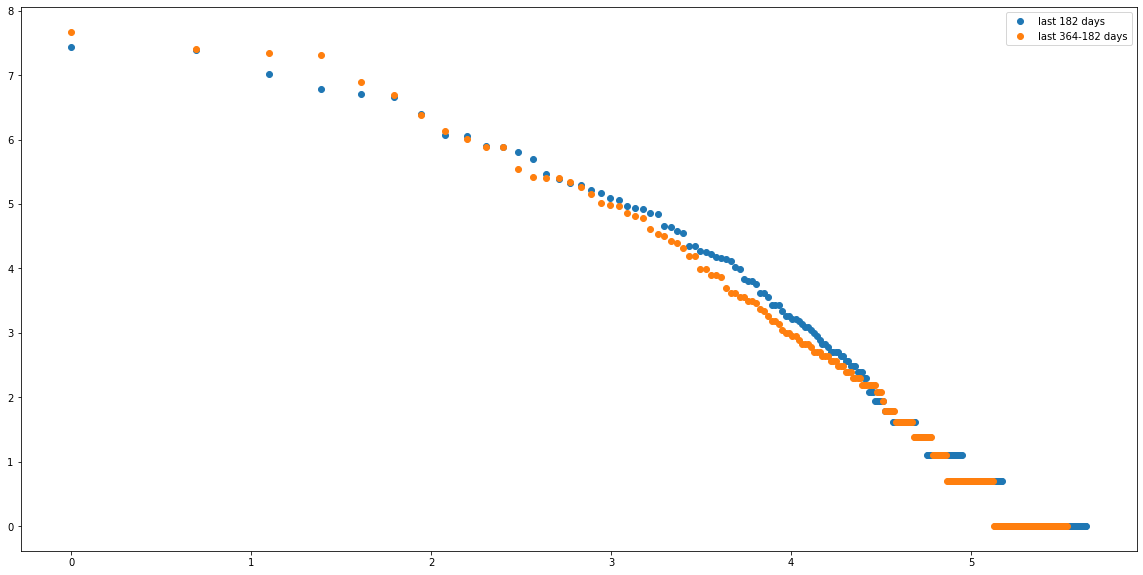

# Rank plot with delta_days=365

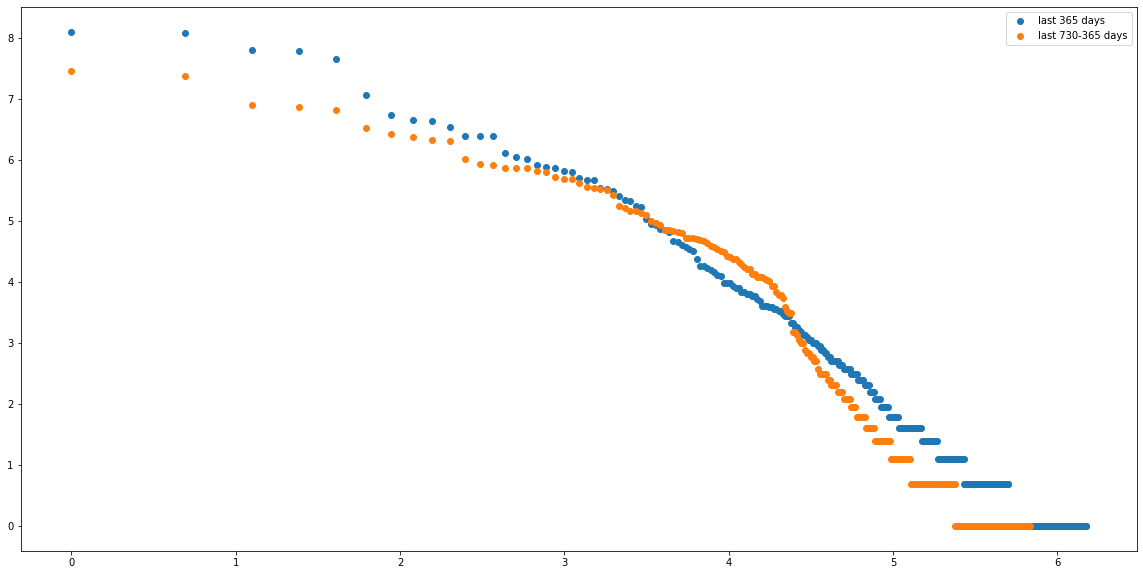

# Rank plot with delta_days=730

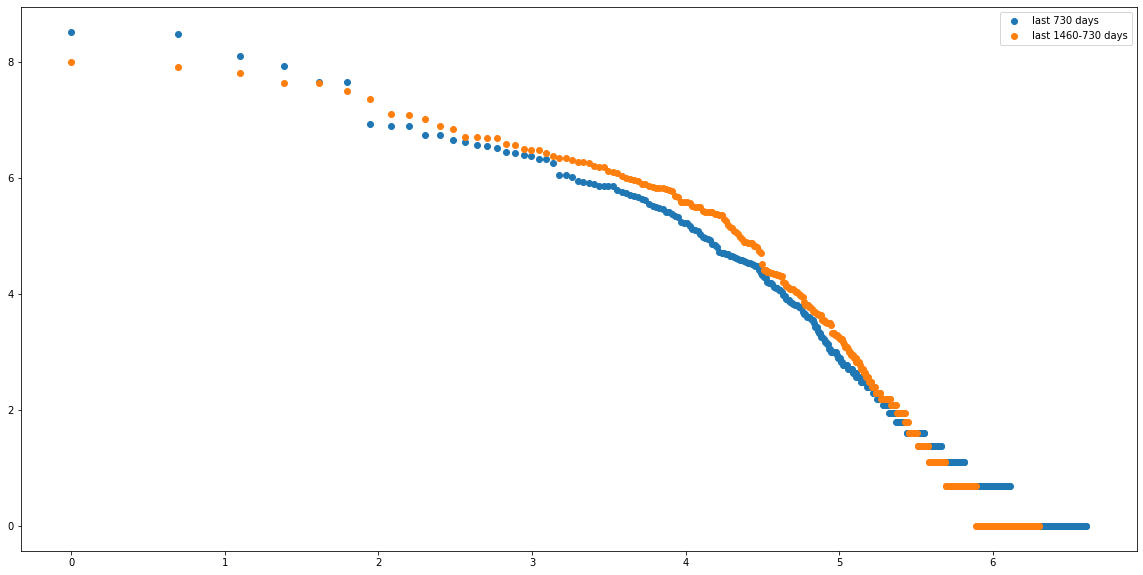

In [176]:
event_types = {
    "Inhaltsbearbeitungen": [5,6],
    "Kommentare": [8,9,14,16],
    "Reviewing": [6,11],
    "Taxonomy": [1,2,12,15,17],
    "Administratives": [10,13]
}

for event_type, event_ids in event_types.items():
    display(Markdown(f"# Event-Type: {event_type}"))
    
    for delta in [90, 182, 365, 730]:
        plot_delta2(event_log[event_log["event_id"].isin(event_ids)], delta)

# Sankey Diagram

https://chart-studio.plotly.com/~alishobeiri/1591/plotly-sankey-diagrams/#/

In [252]:
import plotly.graph_objects as go

labels = ["== 0", ">= 1", ">= 5", ">= 25", ">= 125", ">= 625"]

def cat_edits(edits):
    if edits >= 625:
        return 5
    if edits >= 125:
        return 4
    if edits >= 25:
        return 3
    if edits >= 5:
        return 2
    if edits >= 1:
        return 1
    return 0

def current(d):
    return count_edits(d[d >= max_date - pd.Timedelta(days=days_delta)])

def before(d):
    return count_edits(d[(d >= max_date - pd.Timedelta(days=2*days_delta)) & (d < max_date - pd.Timedelta(days=days_delta))])

days_delta = 90
event_ids = [5]
max_date = event_log["date"].max()

df = event_log[event_log["date"] > max_date - pd.Timedelta(days=2*days_delta)]
df = df[df["event_id"].isin(event_ids)]
df = df.groupby("username").aggregate({
    "date": [current, before]
})
df.columns = df.columns.droplevel(0)
df["target"] = df["current"].map(cat_edits)
df["source"] = df["before"].map(cat_edits)

df = df.groupby(["source", "target"]).count()
df.reset_index(inplace=True)

sankey=go.Sankey(
    arrangement="snap",
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = 2*labels,
      color = "blue",
      x = [0 for i in range(len(labels))] + [1 for i in range(len(labels))],
      y = 2*[i/len(labels) for i in range(len(labels))],
    ),
    link = dict(
      source = df["source"],
      target = df["target"] + len(labels),
      value = df["current"]
  ))
fig = go.Figure(data=[sankey])

fig.update_layout(title_text=f"Bearbeitungen vorher / nacher", font_size=10)
fig.show()

display(df)

,source,target,current,before
0,0,1,25,25
1,0,2,12,12
2,0,3,5,5
3,0,4,1,1
4,1,0,29,29
5,1,1,10,10
6,1,2,10,10
7,1,3,2,2
8,2,0,8,8
9,2,1,3,3


In [290]:
import plotly.graph_objects as go

labels = ["== 0", ">= 1", ">= 10", ">= 100", ">= 1000"]

def cat_edits(edits):
    if edits >= 1000:
        return 4
    if edits >= 100:
        return 3
    if edits >= 10:
        return 2
    if edits >= 1:
        return 1
    return 0

def current(d):
    return count_edits(d[d >= max_date - pd.Timedelta(days=days_delta)])

def before(d):
    return count_edits(d[(d >= max_date - pd.Timedelta(days=2*days_delta)) & (d < max_date - pd.Timedelta(days=days_delta))])

days_delta = 90
event_ids = [5]
max_date = event_log["date"].max()

df = event_log[event_log["date"] > max_date - pd.Timedelta(days=2*days_delta)]
df = df[df["event_id"].isin(event_ids)]
df = df.groupby("username").aggregate({
    "date": [current, before]
})
df.columns = df.columns.droplevel(0)
df["target"] = df["current"].map(cat_edits)
df["source"] = df["before"].map(cat_edits)

df = df.groupby(["source", "target"]).count()
df.reset_index(inplace=True)

def compute_value(x, ref="source"):
    return x["current"] / df[df[ref] == x[ref]]["current"].sum() * 100

df["value_source"] = df.apply(compute_value, axis=1)
df["value_target"] = df.apply(lambda x: compute_value(x, "target"), axis=1)

display(df)

def sankey(value_name, suffix=""):
    sankey=go.Sankey(
        arrangement="snap",
        valueformat=".0f",
        valuesuffix=suffix,
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = 2*labels,
          color = "blue",
          x = [0 for i in range(len(labels))] + [1 for i in range(len(labels))],
          y = 2*[i/len(labels) for i in range(len(labels))],
        ),
        link = dict(
          source = df["source"],
          target = df["target"] + len(labels),
          value = df[value_name]
      ))
    fig = go.Figure(data=[sankey])

    fig.update_layout(title_text=f"Bearbeitungen vorher / nacher", font_size=10)
    fig.show()

sankey("current")
sankey("value_source", "%")
sankey("value_target", "%")

,source,target,current,before,value_source,value_target
0,0,1,29,29,67.441860,53.703704
1,0,2,12,12,27.906977,30.000000
2,0,3,2,2,4.651163,25.000000
3,1,0,33,33,50.769231,75.000000
4,1,1,20,20,30.769231,37.037037
5,1,2,12,12,18.461538,30.000000
6,2,0,11,11,35.483871,25.000000
7,2,1,5,5,16.129032,9.259259
8,2,2,13,13,41.935484,32.500000
9,2,3,2,2,6.451613,25.000000
